## Model Search

Katherine Haynes <br>
April 12, 2020


# Notes
This notebook attempts to find the best classification model for two datasets by optimizing both data pre-processing options and model hyperparameters.  It does this using both [scikit-learn](https://scikit-learn.org/stable/) and [hyperopt](http://hyperopt.github.io/hyperopt/). 

This notebook expects two folders in the local directory running this notebook:
 - data: Folder with two datasets.
 - save: Folder with saved pickle files to demonstrate results. <br> 

These can be downloaded: https://bit.ly/3jcOjne

All sections in this notebook contain flags to run each analysis, create plots, and display results.  For submission, I have turned all of the calculation flags to false and am reading the results from the saved pickle files.  To perform any new analysis, simply turn the flags for the appropriate section to True. <br>

### Load Libraries

In [1]:
# Load Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas
import pickle
import sys
import time

from hyperopt import fmin, hp, Trials, tpe, space_eval, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import normalize, scale
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.fixes import loguniform

In [2]:
# Set Plotting Sizes
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

# 1 Data

This notebook has the option to run one of two datasets at a time.  First is Wine Quality by [Cortez et al. (2009)](https://doi.org/10.1016/j.dss.2009.05.016), which can be obtained from [Github](https://github.com/simonneutert/wine_quality_data).  This study makes use of the red variant of the "Vinho Verde" wine dataset, which has 11 attributes and 1599 samples.  While this dataset can be used for a variety of classification problems, the goal here is to see if a model can predict wine quality, which ranges from 3 to 8.  A challenge for the model is that the wine quality is imbalanced, with few poor and excellent wines.  Part of this study will be to investigate how many different quality classifications can be learned and predicted.  To use this dataset, set the dataSet variable to 'Wine'.

Second is the Student Performance Data Set by [Cortez et al. (2008)](http://www3.dsi.uminho.pt/pcortez/student.pdf), which can be obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/student+performance).  This study makes use of the Mathematics performances, which has 32 attributes and 395 samples.  The goal of this data is to see if a model can be trained to predict the final grade, which ranges from 0 to 20.  Because there are limited samples, the final grades are grouped into four performance classifications: poor (0-6), below average (7-11), average (12-14), and above average (15-20).  To use this dataset, set the dataSet variable to 'Student'.

In [3]:
dataSet = 'Wine'

In [4]:
# Data Plotting Options
plotAllData = False
plotLabelHist = True

### Load Data

In [5]:
# Open and Read the Data Sets
if dataSet == 'Wine':
    filename = 'data/winequality-red.csv'
    fileVars = ["facid", "vacid", "cacid", "sugar", "chlor", "fso2", "tso2",
               "density", "pH", "sulphates", "alcohol"]
    nCVSplits = 2
    
    allvals = np.loadtxt(filename,delimiter=";", skiprows=1)
    X = allvals[:,0:11]
    Y = allvals[:,11].astype(int)
    
elif dataSet == 'Student':
    filename = 'data/student-mat.csv'
    nCVSplits = 3
 
    allvalsTemp = pandas.read_csv(filename,delimiter=";")
    fileVars = list(allvalsTemp.columns)[:-1]
    
    YTemp = allvalsTemp['G3'].to_numpy()
    Y = YTemp.copy()
    count = 0
    for yVal in YTemp:
       if yVal < 7:
           Y[count] = 1
       elif yVal < 11:
           Y[count] = 2
       elif yVal < 14:
           Y[count] = 3
       elif yVal < 21:
           Y[count] = 4
       count += 1
   
    allvalsTemp['school'] = allvalsTemp['school'].astype('category')
    allvalsTemp['school_cat'] = allvalsTemp['school'].cat.codes
    allvalsTemp['sex'] = allvalsTemp['sex'].astype('category')
    allvalsTemp['sex_cat'] = allvalsTemp['sex'].cat.codes
    allvalsTemp['age_cat'] = allvalsTemp['age']
    allvalsTemp['address'] = allvalsTemp['address'].astype('category')
    allvalsTemp['address_cat'] = allvalsTemp['address'].cat.codes
    allvalsTemp['famsize'] = allvalsTemp['famsize'].astype('category')
    allvalsTemp['famsize_cat'] = allvalsTemp['famsize'].cat.codes
    allvalsTemp['Pstatus'] = allvalsTemp['Pstatus'].astype('category')
    allvalsTemp['pstatus_cat'] = allvalsTemp['Pstatus'].cat.codes
    allvalsTemp['medu_cat'] = allvalsTemp['Medu']
    allvalsTemp['fedu_cat'] = allvalsTemp['Fedu']
    allvalsTemp['Mjob'] = allvalsTemp['Mjob'].astype('category')
    allvalsTemp['mjob_cat'] = allvalsTemp['Mjob'].cat.codes
    allvalsTemp['Fjob'] = allvalsTemp['Fjob'].astype('category')
    allvalsTemp['fjob_cat'] = allvalsTemp['Fjob'].cat.codes
    allvalsTemp['reason'] = allvalsTemp['reason'].astype('category')
    allvalsTemp['reason_cat'] = allvalsTemp['reason'].cat.codes
    allvalsTemp['guardian'] = allvalsTemp['guardian'].astype('category')
    allvalsTemp['guardian_cat'] = allvalsTemp['guardian'].cat.codes
    allvalsTemp['traveltime_cat'] = allvalsTemp['traveltime']
    allvalsTemp['studytime_cat'] = allvalsTemp['studytime']
    allvalsTemp['failures_cat'] = allvalsTemp['failures']
    allvalsTemp['schoolsup'] = allvalsTemp['schoolsup'].astype('category')
    allvalsTemp['schoolsup_cat'] = allvalsTemp['schoolsup'].cat.codes
    allvalsTemp['famsup'] = allvalsTemp['famsup'].astype('category')
    allvalsTemp['famsup_cat'] = allvalsTemp['famsup'].cat.codes
    allvalsTemp['paid'] = allvalsTemp['paid'].astype('category')
    allvalsTemp['paid_cat'] = allvalsTemp['paid'].cat.codes
    allvalsTemp['activities'] = allvalsTemp['activities'].astype('category')
    allvalsTemp['activities_cat'] = allvalsTemp['activities'].cat.codes
    allvalsTemp['nursery'] = allvalsTemp['nursery'].astype('category')
    allvalsTemp['nusery_cat'] = allvalsTemp['nursery'].cat.codes
    allvalsTemp['higher'] = allvalsTemp['higher'].astype('category')
    allvalsTemp['higher_cat'] = allvalsTemp['higher'].cat.codes
    allvalsTemp['internet'] = allvalsTemp['internet'].astype('category')
    allvalsTemp['internet_cat'] = allvalsTemp['internet'].cat.codes
    allvalsTemp['romantic'] = allvalsTemp['romantic'].astype('category')
    allvalsTemp['romantic_cat'] = allvalsTemp['romantic'].cat.codes
    allvalsTemp['famrel_cat'] = allvalsTemp['famrel']
    allvalsTemp['freetime_cat'] = allvalsTemp['freetime']
    allvalsTemp['goout_cat'] = allvalsTemp['goout']
    allvalsTemp['Dalc_cat'] = allvalsTemp['Dalc']
    allvalsTemp['Walc_cat'] = allvalsTemp['Walc']
    allvalsTemp['health_cat'] = allvalsTemp['health']
    allvalsTemp['absences_cat'] = allvalsTemp['absences']
    allvalsTemp['g1_cat'] = allvalsTemp['G1']
    allvalsTemp['g2_cat'] = allvalsTemp['G2']
    X = allvalsTemp.loc[:,'school_cat':].to_numpy()
    
nVars = len(fileVars)
print('Finished Loading {} Dataset.'.format(dataSet))

Finished Loading Wine Dataset.


In [6]:
# Create Scatter Plots of Data Attributes
if plotAllData:
    nVars = len(fileVars)
    for i in range(nVars):
        plt.scatter(Y,X[:,i])
        plt.title(fileVars[i])
        plt.show()

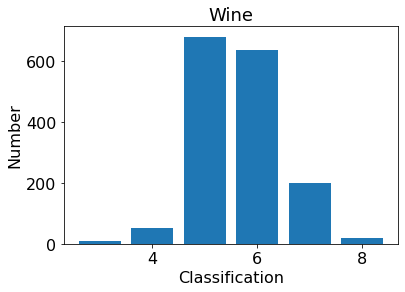

In [7]:
# Show Label Histogram
if plotLabelHist:
    histNums, histOut = np.unique(Y, return_counts=True)
    plt.bar(histNums,histOut)
    plt.title(dataSet)
    plt.ylabel('Number')
    plt.xlabel('Classification')

### Split Data into Training and Testing

For this study, I used 80% of the data for training and 20% for testing.  Since the wine dataset is significantly imbalanced, care was taken to ensure both subsets maintain the original classification distribution.  Additionally, all evaluation will be done using the balanced accuracy scoring method.

In [8]:
testFrac = 0.2
printTTDists = True
plotTestTrainVars = False
scoreMethod = 'balanced_accuracy'

In [9]:
# Make a train/test split
if testFrac > 0.0:
    # If you don't care about the distribution,
    #  you can use:
    #X_train, X_test, y_train, y_test = train_test_split(
    #    X, Y, test_size=testFrac)
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=testFrac)
    for traini, testi in sss.split(X, Y):
        X_train, X_test = X[traini], X[testi]
        y_train, y_test = Y[traini], Y[testi]
    print("Split Data Set into Train and Test Subsets.")
    
    # Check distribution:
    if printTTDists:
       uniqueA, countsA = np.unique(Y, return_counts=True)
       unique, counts = np.unique(y_train, return_counts=True)
       uniqueT, countsT = np.unique(y_test, return_counts=True)
       np.set_printoptions(precision=3)
       print('Orig Dist : ',countsA/np.sum(countsA))
       print('Train Dist: ',counts/np.sum(counts))
       print('Test Dist : ',countsT/np.sum(countsT))
    
else:
    X_train = X
    X_test = X
    y_train = Y
    y_test = Y

Split Data Set into Train and Test Subsets.
Orig Dist :  [0.006 0.033 0.426 0.399 0.124 0.011]
Train Dist:  [0.006 0.033 0.426 0.399 0.124 0.012]
Test Dist :  [0.006 0.034 0.425 0.4   0.125 0.009]


In [10]:
# Show the variables in the test and train splits
if plotTestTrainVars:
   fig, axs = plt.subplots(nrows=nVars,ncols=2)
   fig.set_size_inches(20,40)
   cref=0
   rref=0
   mySize=16
   for i in range(nVars):
       axs[rref,cref].scatter(y_train,X_train[:,i])
       axs[rref,cref].tick_params(axis='both',labelsize=mySize)
       if (i == 0):
           tString = "Train " + fileVars[i]
           axs[rref,cref].set_title(tString,fontsize=mySize)
       else:
           axs[rref,cref].set_title(fileVars[i],fontsize=mySize)
       cref+=1
    
       axs[rref,cref].scatter(y_test,X_test[:,i])
       axs[rref,cref].tick_params(axis='both',labelsize=mySize)
       if (i == 0):
           tString = "Test " + fileVars[i]
           axs[rref,cref].set_title(tString,fontsize=mySize)
       else:
           axs[rref,cref].set_title(fileVars[i],fontsize=mySize)
       rref+=1
       cref=0
   fig.subplots_adjust(hspace=0.3)

# 2 Model Search Space

The model search space is divided into two areas: building features and search features.  

### Model Building Features <br>
Model building features are what I will consider to be options during the data pre-processing phase.  This search space consists of four elements:
* <b>Attribute/Feature Selection.</b>
Input variables are selected according to the highest score using the Chi-Squared Statistic.  For both datasets, the number of features in the search space ranges from two up to the number of variables provided in the dataset. <br><br>
* <b>Normalization.</b>
The input variables can be scaled to unit length, and the search space for both datasets includes the original input and the normalized variables. <br><br>
* <b>Scaling.</b>
The input variables can be standardized such that the mean is zero and scaled to unit variance, and the search space for both datasets includes the both scaled and non-scaled variables. <br><br>
* <b>Output Classification.</b>
For the wine dataset, different categories of quality can be tried depending on the exact usage and performance.  In this study, I will consider using all original classifications (6 quality values ranging from 3-8) and using two different selections processes to obtain 3 quality values, corresponding to low, mid, and high quality.  The first (BAG1) is to divide the categories evenly by original number: bad=1-3, mid=4-7, and high=8-10.  The second (BAG2) is to divide the categories more evenly by actual counts: bad=1-4, mid=5-6, and high=7-10.

### Model Search Features <br>
Model search features are what I will consider to be all available classification models and their associated parameters (model and hyperparameter optimization).  Since both datasets are classification problems, the model search space is the same for both and consists of eight different classifiers and their associated parameters:
* [<b>AdaBoost (Ada)</b>](https://scikit-learn.org/stable/modules/ensemble.html#fs1995) <br>
AdaBoost is a popular boosting algorithm ([Freund and Schapire, 1997](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier), which fits a sequence of weak learners on repeatedly modified data versions, where a final prediction results from a weighted majority vote from the learners.  <br> <b>Parameter Search Space:</b> The number of estimators (n_estimators), with options tested from 20 to 120. <br><br>

* [<b>Bernoulli Naive Bayes (CNB)</b>](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB) <br>
The Bernoulli Naive Bayes algorithm uses the Naive Bayes technique for data that is distributed according to multivariate Bernoulli distributions.  For samples that are not binary-valued vectors, the algorithm binarizes the input and assigns class labels to a combination of features that are assumed to be independent using conditional probabilities.  <br> <b>Parameter Search Space:</b> The additive smoothing parameter (alpha), with options tested from 0 to 1.
<br><br>

* [<b>Decision Tree (Tree)</b>](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) <br>
The classic decision tree classifier that learns decision rules inferred from data features.  <br><b>Parameter Search Space:</b> 1) The splitting criterion (criterion), with both the Gini impurity and the entropy information gain methods tested.  2) The maximum depth of the tree (max_depth), with options tested from 2 to 20.  3) The maximum number of features (max_features), defining the number of features considered for optimal splits, with the options being auto, sqrt, log2, and None. <br><br>

* [<b>Gradient Boosting (GBC)</b>](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)<br>
A method designed to boost weak learners to strong learners by optimizing a differentiable loss function.  <br><b>Parameter Search Space:</b> 1) The learning rate defining the contribution of each tree (learning_rate), with options tested from 0.001 to 1. 2) The maximum number of features for the best split (max_features), with four options of None, auto, sqrt, and log2 tested.  3)  The number of boosting stages to perform (n_estimators), with options tested from 1 to 200. <br><br>

* [<b>Gaussian Naive Bayes (GNB) </b>](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) <br>
Naive Bayes classification algorithm where the likelihood of the features is assumed to be Gaussian.  The implementation is based on the algorithm by [Chan et al. (1979)](http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf). <br> <b>Parameter Search Space:</b> The portion of the largest variance of all features that is added to variances for calculation stability (var_smoothing), with options tested from 1.e-9 to 1.e-7. <br><br>

* [<b> k-Nearest Neighbors (KNN)</b>](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) <br>
A neighbor-based classification approach that uses the plurality vote of the nearest neighbors to each point. <br><b>Parameter Search Space:</b> 1) The algorithm used to compute the nearest neighbors, with options tested including BallTree, KDTree, and brute force.  2) The leaf size passed to [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) or [KDTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree), with options tested from 2 to 6.  3) The number of neighbors to use for the queries (n_neighbors), with options tested from 2 to 50.  4) The weight function used in prediction (weights), with the options of uniform or distance. <br><br>

* [<b>Random Forest (Forest)</b>](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) <br>
The classic random forest classifier that fits a number of decision trees on sub-samples of the dataset, averaging the results in an effort to improve accuracy and avoid over-fitting. <br> <b>Parameter Search Space:</b> 1) The splitting criterion (criterion), with both the Gini impurity and entropy information gain methods tested.  2) The maximum depth of the tree (max_depth), with options tested from 2 to 50. 3) The maximum number of features (max_features), defining the number of features considered for optimal splits, with the options being auto, sqrt, log2, and None.  4) The splitting strategy used for each node (splitter), with the options being best and random. <br><br>

* [<b>Support Vector Classification (SVM)</b>](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.fit) <br>
Multi-class classification using SVC implements the "one-against-one" approach by [Knerr et al. (1990)](https://www.bibsonomy.org/bibtexkey/StepwiseNN/juffi), where training vectors are implicitly mapped into higher dimensional space using a cost function (kernel). <br><b>Parameter Search Space:</b> 1) The regularization parameter (C), with options tested from .001 to 1. 2) The kernel type (kernel), including the options of linear, poly, rbf, and sigmoid.  3) The degree of the polynomial kernel function (degree), with options tested from 1 to 10.

### [Hyperopt](http://jaberg.github.io/hyperopt/)
Both the model building and model parameter features will be searched using [Hyperopt](http://proceedings.mlr.press/v28/bergstra13.pdf).  Hyperopt automates hyperparameter optimization using either a random or guided approach. Hyperopt has the capability to combine both model building and parameter searches into a single defined search space that is used for both random and guided searches.  Two separate search spaces are defined for the two datasets in order to add the target search for the Wine dataset.

In [11]:
# HYPEROPT DEFINITIONS
classifierList = ['ada','bNB','forest','gbc','gaussNB','knn','svm','tree']

nVarsWine = 12
spaceWine = hp.choice('classifier_type', [
         { 'type': 'ada',
           'n_estimators': hp.choice('ada_estimators',range(20,120)),
           'n_features': hp.choice('ada_nfeatures', range(2,nVarsWine)),
           'n_targets': hp.choice('ada_ntargets', ["All","BAG1","BAG2"]),
           'normalize': hp.choice('ada_normalize', [0, 1]),
           'scale': hp.choice('ada_scale', [0, 1])
         },
         { 'type': 'bNB',
           'alpha': hp.uniform('bNB', 0.0, 2.0),
           'n_features': hp.choice('bNB_nfeatures', range(2,nVarsWine)),
           'n_targets': hp.choice('bNB_ntargets', ["All","BAG1","BAG2"]),
           'normalize': hp.choice('bNB_normalize', [0, 1]),
           'scale': hp.choice('bNB_scale', [0, 1])
         },
         { 'type': 'forest',
           'criterion': hp.choice('forest_criterion', ["gini","entropy"]),
           'max_depth': hp.choice('forest_depth', [None, 5, 10, 20]),
           'max_features': hp.choice('forest_features', 
                                     [None,"auto","sqrt","log2"]),
           'n_estimators': hp.choice('forest_estimators', range(10,200)),
           'n_features': hp.choice('forest_nfeatures', range(2,nVarsWine)),
           'n_targets': hp.choice('forest_ntargets', ["All","BAG1","BAG2"]),
           'normalize': hp.choice('forest_normalize', [0, 1]),
           'scale': hp.choice('forest_scale', [0, 1]),
         },
         { 'type': 'gbc',
           'learning_rate': hp.lognormal('gbc_lrate',0,1),
           'max_features': hp.choice('gbc_maxfeatures', 
                                     [None,"auto","sqrt","log2"]),
           'n_estimators': hp.choice('gbc_nestimators', range(50,200)),  
           'n_features': hp.choice('gbc_nfeatures', range(2,nVarsWine)),
           'n_targets': hp.choice('gbc_ntargets', ["All","BAG1","BAG2"]),
           'normalize': hp.choice('gbc_normalize', [0, 1]),
           'scale': hp.choice('gbc_scale', [0, 1])
         },
         { 'type': 'gNB',
           'n_features': hp.choice('gaussNB_nfeatures', range(2,nVarsWine)),
           'n_targets': hp.choice('gaussNB_ntargets', ["All","BAG1","BAG2"]),
           'normalize': hp.choice('gaussNB_normalize', [0, 1]),
           'scale': hp.choice('gaussNB_scale', [0, 1]),
           'var_smoothing': hp.uniform('gaussNB_smoothing', 1.e-10, 1.e-8)
         },
         { 'type': 'knn',
           'algorithm': hp.choice('knn_algorithm',
                                 ["ball_tree","brute","kd_tree"]),
           'leaf_size': hp.choice('knn_leafsize', range(2,10)),
           'n_features': hp.choice('knn_nfeatures', range(2,nVarsWine)),
           'n_neighbors': hp.choice('knn_nneighbors', range(2,50)),
           'n_targets': hp.choice('knn_ntargets', ["All","BAG1","BAG2"]),
           'normalize': hp.choice('knn_normalize', [0, 1]),
           'scale': hp.choice('knn_scale', [0, 1]),
           'weights': hp.choice('knn_weights', ["uniform","distance"])
         },
         { 'type': 'svm',
           'C': hp.lognormal('svm_C',0,1),
           'degree': hp.choice('svm_degree',range(1,10)),
           'kernel': hp.choice('svm_kernel', ["linear","poly","rbf","sigmoid"]),
           'n_features': hp.choice('svm_nfeatures', range(2,nVarsWine)),
           'n_targets': hp.choice('svm_ntargets', ["All","BAG1","BAG2"]),
           'normalize': hp.choice('svm_normalize', [0, 1]),
           'scale': hp.choice('svm_scale', [0, 1])
         },
         { 'type': 'tree',
           'criterion': hp.choice('tree_criterion', ["gini","entropy"]),
           'max_depth': hp.choice('tree_depth', [None, 5, 10, 20]),
           'max_features': hp.choice('tree_features', 
                                     [None,"auto","sqrt","log2"]),
           'n_features': hp.choice('tree_nfeatures', range(2,nVarsWine)),
           'n_targets': hp.choice('tree_ntargets', ["All","BAG1","BAG2"]),
           'normalize': hp.choice('tree_normalize', [0, 1]),
           'scale': hp.choice('tree_scale', [0, 1]),
           'splitter': hp.choice('tree_splitter', ["best","random"])
         }
])

nVarsStudent = 32
spaceStudent = hp.choice('classifier_type', [
         { 'type': 'ada',
           'n_estimators': hp.choice('ada_estimators',range(20,120)),
           'n_features': hp.choice('ada_nfeatures', range(2,nVarsStudent)),
           'normalize': hp.choice('ada_normalize', [0, 1]),
           'scale': hp.choice('ada_scale', [0, 1])
         },
         { 'type': 'bNB',
           'alpha': hp.uniform('bNB', 0.0, 2.0),
           'n_features': hp.choice('bNB_nfeatures', range(2,nVarsStudent)),
           'normalize': hp.choice('bNB_normalize', [0, 1]),
           'scale': hp.choice('bNB_scale', [0, 1])
         },
         { 'type': 'forest',
           'criterion': hp.choice('forest_criterion', ["gini","entropy"]),
           'max_depth': hp.choice('forest_depth', [None, 5, 10, 20]),
           'max_features': hp.choice('forest_features', 
                                     [None,"auto","sqrt","log2"]),
           'n_estimators': hp.choice('forest_estimators', range(10,200)),
           'n_features': hp.choice('forest_nfeatures', range(2,nVarsStudent)),
           'normalize': hp.choice('forest_normalize', [0, 1]),
           'scale': hp.choice('forest_scale', [0, 1]),
         },
         { 'type': 'gbc',
           'learning_rate': hp.lognormal('gbc_lrate',0,1),
           'max_features': hp.choice('gbc_maxfeatures', 
                                     [None,"auto","sqrt","log2"]),
           'n_estimators': hp.choice('gbc_nestimators', range(50,200)),  
           'n_features': hp.choice('gbc_nfeatures', range(2,nVarsStudent)),
           'normalize': hp.choice('gbc_normalize', [0, 1]),
           'scale': hp.choice('gbc_scale', [0, 1])
         },
         { 'type': 'gNB',
           'n_features': hp.choice('gaussNB_nfeatures', range(2,nVarsStudent)),
           'normalize': hp.choice('gaussNB_normalize', [0, 1]),
           'scale': hp.choice('gaussNB_scale', [0, 1]),
           'var_smoothing': hp.uniform('gaussNB_smoothing', 1.e-10, 1.e-8)
         },
         { 'type': 'knn',
           'algorithm': hp.choice('knn_algorithm',
                                 ["ball_tree","brute","kd_tree"]),
           'leaf_size': hp.choice('knn_leafsize', range(2,10)),
           'n_features': hp.choice('knn_nfeatures', range(2,nVarsStudent)),
           'n_neighbors': hp.choice('knn_nneighbors', range(2,50)),
           'normalize': hp.choice('knn_normalize', [0, 1]),
           'scale': hp.choice('knn_scale', [0, 1]),
           'weights': hp.choice('knn_weights', ["uniform","distance"])
         },
         { 'type': 'svm',
           'C': hp.lognormal('svm_C',0,1),
           'degree': hp.choice('svm_degree',range(1,10)),
           'kernel': hp.choice('svm_kernel', ["linear","poly","rbf","sigmoid"]),
           'n_features': hp.choice('svm_nfeatures', range(2,nVarsStudent)),
           'normalize': hp.choice('svm_normalize', [0, 1]),
           'scale': hp.choice('svm_scale', [0, 1])
         },
         { 'type': 'tree',
           'criterion': hp.choice('tree_criterion', ["gini","entropy"]),
           'max_depth': hp.choice('tree_depth', [None, 5, 10, 20]),
           'max_features': hp.choice('tree_features', 
                                     [None,"auto","sqrt","log2"]),
           'n_features': hp.choice('tree_nfeatures', range(2,nVarsStudent)),
           'normalize': hp.choice('tree_normalize', [0, 1]),
           'scale': hp.choice('tree_scale', [0, 1]),
           'splitter': hp.choice('tree_splitter', ["best","random"])
         }
])

if dataSet == 'Wine':
    space = spaceWine
elif dataSet == 'Student':
    space = spaceStudent

In [12]:
# HYPEROPT OPTIMIZATION FUNCTIONS
def hyperopt_train_test(params, dUse='cv', printY=False):
      
    # Set the data
    XT_ = X_test[:,:]
    yT_ = y_test[:]
    X_ = X_train[:,:]
    y_ = y_train[:]
        
    # Set the number of cross validation folds
    dCV = StratifiedKFold(n_splits=nCVSplits, shuffle=True)
    
    if 'n_features' in params:
        nFeatures = params['n_features']
        if nFeatures < nVars:
            mySelect = SelectKBest(chi2, k=nFeatures)
            X_ = mySelect.fit_transform(X_, y_)
            XT_ = mySelect.fit_transform(XT_, yT_)
        del params['n_features']
           
    if 'n_targets' in params:
        cDesc = params['n_targets']
        y_ = comboTargets(y_, cDesc=cDesc)
        yT_ = comboTargets(yT_, cDesc=cDesc)
        del params['n_targets']
           
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
            XT_ = normalize(XT_)
        del params['normalize']
                
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
            XT_ = scale(XT_)
        del params['scale']

    t = params['type']
    del params['type']
    if t == 'ada':
        clf = AdaBoostClassifier(**params)
    elif t == 'bNB':
        clf = BernoulliNB(**params)
    elif t == 'forest':
        clf = RandomForestClassifier(**params)
    elif t == 'gbc':
        clf = GradientBoostingClassifier(**params)
    elif t == 'gNB':
        clf = GaussianNB(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    elif t == 'svm':
        clf = SVC(**params)
    elif t == 'tree':
        clf = DecisionTreeClassifier(**params)
    else:
        print('!!!UNKNOWN CLASSIFIER TYPE!!!')
        print('Classifier Tried: {}'.format(t))
        sys.exit()

    clf.fit(X_, y_)
    if dUse == 'test':
        yT_predict = clf.predict(XT_)
        if printY:
           print("Number of Cases: {}".format(yT_.shape[0]))
           print("Y TRUTH:")
           print(yT_.tolist())
           print("Y PREDICT:")
           print(yT_predict.tolist())
           print("Mistmatch Locations:")
           print(np.where(yT_predict != yT_))
        if (scoreMethod == 'balanced_accuracy'):
            return balanced_accuracy_score(yT_,yT_predict)
        else:
            return accuracy_score(yT_,yT_predict)

    elif dUse == 'train':
        y_predict = clf.predict(X_)
        if printY:
            y_predict = clf.predict(X_)
            print("Number of Cases: {}".format(y_.shape[0]))
            print("Y TRUTH:")
            print(y_.tolist())
            print("Y PREDICT:")
            print(y_predict.tolist())
            print("Mismatch Locations:")
            print(np.where(y_predict != y_))
        if (scoreMethod == 'balanced_accuracy'):
            return balanced_accuracy_score(y_,y_predict)
        else:
            return accuracy_score(y_,y_predict)
    
    else:
        return cross_val_score(clf, X_, y_, cv=dCV,
                               scoring=scoreMethod).mean()
    
def f(params):
    global bestA, countA
    countA += 1
    acc = hyperopt_train_test(params.copy())
    if acc > bestA:
        bestA = acc
    if countA % nPrintInfo == 0:
        print('Count: {}, Accuracy: {:.2f}, Params: {}'.format(
              countA, acc*100.,params))
    return {'loss': -acc, 'status':STATUS_OK}

In [13]:
# TARGET COMBINATION PRE-PROCESSING FUNCTION
def comboTargets(yOrig, cDesc='All'):
    yNew = yOrig.copy()
    count = 0
    if cDesc == 'BG':
        for yVal in yOrig:
            if yVal >= 1 and yVal <= 5:
                yNew[count] = 1
            elif yVal >= 6 and yVal <= 10:
                yNew[count] = 2
            count += 1
            
    if cDesc == 'BAG1':
        for yVal in yOrig:
            if yVal >= 1 and yVal <=3:
                yNew[count] = 1
            elif yVal >= 4 and yVal <= 7:
                yNew[count] = 2
            elif yVal >= 8 and yVal <= 10:
                yNew[count] = 3
            count += 1
            
    elif cDesc == 'BAG2':
        for yVal in yOrig:
            if yVal >= 1 and yVal <=4:
                yNew[count] = 1
            elif yVal >= 5 and yVal <= 6:
                yNew[count] = 2
            elif yVal >= 7 and yVal <= 10:
                yNew[count] = 3
            count += 1
               
    elif cDesc == 'S5':
        for yVal in yOrig:
            if yVal < 5:
                yNew[count] = 1
            elif yVal < 10:
                yNew[count] = 2
            elif yVal < 15:
                yNew[count] = 3
            elif yVal <20:
                yNew[count] = 4
                
    return yNew


### [Scikit-Learn](https://scikit-learn.org/stable/index.html)

Scikit-Learn will be used to evaluate impactful model building and search features.  To separate the impacts of the pre-processing and parameter searches, two separate search spaces are defined.  Additionally, it is necessary to create separate search spaces for the random and grid searches, both of which will be used in the sensitivity studies.

In [14]:
# SCIKIT-LEARN DEFINITIONS
classifierList = ['ada','bNB','forest','gbc','gaussNB','knn','svm','tree']
skNames = ["AdaBoost","BernoulliNB","Forest","GradientBoost","GaussianNB",
           "KNN","SVM","Tree"]

skClassifiers = [
    AdaBoostClassifier(),
    BernoulliNB(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier()
]

skRandom = [
    {'n_estimators': range(5,120),
     'learning_rate': loguniform(1e-3,1e0)},
    {'alpha': np.power(10, np.arange(-4,1,dtype=float))},
    {'criterion': ["gini","entropy"],
     'max_depth': np.arange(1,50,dtype=int),
     'max_features': [None,"auto","sqrt","log2"]},
    {'learning_rate': loguniform(1e-3,1e0),
     'max_features': [None,"auto","sqrt","log2"],
     'n_estimators': range(1,200)},
    {'var_smoothing': loguniform(1e-10,1e-7)},
    {'algorithm':["ball_tree","brute","kd_tree"],
     'leaf_size': range(2,6),
     'n_neighbors': range(2,50),
     'weights': ["uniform","distance"]},
    {'C': loguniform(1e-3,1e1),
     'degree': range(1,10),
     'kernel': ["linear","poly","rbf","sigmoid"]},
    {'criterion': ["gini","entropy"],
     'max_depth': range(1,20),
     'max_features': [None,"auto","sqrt","log2"],
     'splitter': ["best","random"]}
]

skGrid = [
    {'n_estimators': [5,10,15,20,25,50,75,100],
     'learning_rate': [0.05, 0.075, 0.1, 0.5, 0.75, 1.0]},
    {'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]},
    {'criterion': ["gini","entropy"],
     'max_depth': [None, 5, 10, 20],
     'max_features': [None,"auto","sqrt","log2"]},
    {'learning_rate': [0.05, 0.075, 0.1, 0.5, 0.75, 1.0],
     'max_features': [None,"auto","sqrt","log2"],
     'n_estimators': [50,75,100,125,150,175,200]},
    {'var_smoothing': [1.e-10, 5.e-10, 1.e-9, 5.e-9, 1.e-8]},
    {'algorithm': ["ball_tree","brute","kd_tree"],
     'leaf_size': [2,3,4,5],
     'n_neighbors': [2,4,6,8,10,12,15,20,25,50],
     'weights': ["uniform","distance"]},
    {'C': [0.05, 0.075, 0.1, 0.5, 0.75, 1.0],
     'degree': [1,2,3,4,5,6,8,10],
     'kernel': ["linear","poly","rbf","sigmoid"]},
    {'criterion': ["gini","entropy"],
     'max_depth': [None, 5, 10, 20],
     'max_features': [None,"auto","sqrt","log2"],
     'splitter': ["best","random"]}
]

if dataSet == 'Wine':
   skDataOptions = {'n_features':[2,3,4,5,6,7,8,9,10,11],
                 'n_targets': ['All','BG','BAG1','BAG2'],
                 'normalize': [0, 1],
                 'scale': [0,1]}
elif dataSet == 'Student':
   skDataOptions = {
                 'n_features':[8,12,16,20,24,28,32],
                 'normalize': [0, 1],
                 'scale': [0,1]}

In [15]:
# SCIKIT-LEARN TEST FUNCTIONS
def testCLF(name, params):
    if name == 'AdaBoost':
        tclf = AdaBoostClassifier(**params)
    elif name == 'BernoulliNB':
        tclf = BernoulliNB(**params)
    elif name == 'Forest':
        tclf = RandomForestClassifier(**params)
    elif name == 'GradientBoost':
        tclf = GradientBoostingClassifier(**params)
    elif name == 'GaussianNB':
        tclf = GaussianNB(**params)
    elif name == 'KNN':
        tclf = KNeighborsClassifier(**params)
    elif name == 'SVM':
        tclf = SVC(**params)
    elif name == 'Tree':
        tclf = DecisionTreeClassifier(**params)
    else:
        print("Unknown Classifier To Test. Stopping.")
        sys.exit()
        
    tclf.fit(X_train, y_train)
    y_predict = tclf.predict(X_test)
    return balanced_accuracy_score(y_test, y_predict)

def testCLFP(params, pConf=False, pSave=False, 
             pFile='', pTitle=dataSet, pNorm=None):
    
    # Set the data
    XT_ = X_test[:,:]
    yT_ = y_test[:]
    X_ = X_train[:,:]
    y_ = y_train[:]
    
    if 'n_features' in params:
        nFeatures = params['n_features']
        if nFeatures < nVars:
            mySelect = SelectKBest(chi2, k=nFeatures)
            X_ = mySelect.fit_transform(X_, y_)
            XT_ = mySelect.fit_transform(XT_, yT_)
        del params['n_features']
           
    if 'n_targets' in params:
        cDesc = params['n_targets']
        y_ = comboTargets(y_, cDesc=cDesc)
        yT_ = comboTargets(yT_, cDesc=cDesc)
        del params['n_targets']
           
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
            XT_ = normalize(XT_)
        del params['normalize']
                
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
            XT_ = scale(XT_)
        del params['scale']
        
    name = params['type']
    del params['type']
    
    if name == 'ada':
        tclf = AdaBoostClassifier(**params)
    elif name == 'bNB':
        tclf = BernoulliNB(**params)
    elif name == 'forest':
        tclf = RandomForestClassifier(**params)
    elif name == 'gbc':
        tclf = GradientBoostingClassifier(**params)
    elif name == 'gNB':
        tclf = GaussianNB(**params)
    elif name == 'knn':
        tclf = KNeighborsClassifier(**params)
    elif name == 'svm':
        tclf = SVC(**params)
    elif name == 'tree':
        tclf = DecisionTreeClassifier(**params)
    else:
        print("Unknown Classifier To Test. Stopping.")
        sys.exit()
        
    tclf.fit(X_, y_)
    y_predict = tclf.predict(XT_)
    
    if pConf:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
        disp = plot_confusion_matrix(tclf, XT_, yT_, cmap=plt.cm.Blues, 
                                     normalize=pNorm, ax=ax)
        ax.set_title(pTitle)
        
        if pSave:
            plt.savefig(pFile,bbox_inches='tight')
        
    return y_predict, yT_


# 3 Model Validation

I will use both a train/test split and cross-validation to evaluate my models.  The hyperparameter optimization will be conducted on the training split; however, to find the best options and avoid overfitting I will use cross-validation in the parameter searches.  Since the Wine quality classification is unbalanced, I will use a stratified 2-fold for this dataset.  For the Student dataset, I will use stratified 3-fold cross-validation. 

Once the optimal options and parameters have been found using the training dataset, the final model selection will be based on model performance for the testing split.  The top ten models from both a random search and a guided search on the training data (using cross-validation) will then be evaluated on the hold-out testing data for final model recommendations.

# 4 Random Search

Hyperopt offers a random search, and that is what will be used for the primary random search in this assignment since it easily allows for the pre-processing and parameter searching to be done concurrently.

In [16]:
nRMaxEvals = 10
nPrintInfo = 2

randomSearchHP = True
randomSearchHPSave = False
randomHPSaveFile = dataSet + '_rHPResults' + str(nRMaxEvals) + '.pickle'

In [17]:
# RANDOM SEARCH USING HYPEROPT
if randomSearchHP:
   print()
   countA = 0
   bestA = 0
    
   start_time = time.time()
   rTrials = Trials()
   bestRS = fmin(f, space, algo=tpe.rand.suggest, max_evals=nRMaxEvals,
                 trials=rTrials)
   bestRA = bestA
   bestRSpace = space_eval(space, bestRS)
   rTime = time.time() - start_time
   
   # Save results to pickle file
   if randomSearchHPSave:
      with open(randomHPSaveFile, 'wb') as handle:
            pickle.dump([bestRA, bestRSpace, rTrials, rTime], handle, 
                        protocol=pickle.HIGHEST_PROTOCOL)
   
   print('')
   print('--------------------------------------')
   print('Finished Random Model Search in {:.3f}s'.format(rTime))
   print('Best Parameters: {}'.format(bestRSpace))
   print('Best CV Train Accuracy: {}'.format(bestRA*100.))
   print('Best Train Accuracy: {:.3f}'.format(
       hyperopt_train_test(bestRSpace.copy(),dUse='train')*100.))
   print('Best Test Accuracy: {:.3f}'.format(
       hyperopt_train_test(bestRSpace.copy(),dUse='test')*100.))
   print('')


Count: 2, Accuracy: 33.09, Params: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 138, 'n_features': 5, 'n_targets': 'All', 'normalize': 0, 'scale': 0, 'type': 'forest'}
Count: 4, Accuracy: 22.52, Params: {'algorithm': 'kd_tree', 'leaf_size': 7, 'n_features': 8, 'n_neighbors': 22, 'n_targets': 'All', 'normalize': 1, 'scale': 1, 'type': 'knn', 'weights': 'uniform'}
Count: 6, Accuracy: 21.76, Params: {'n_estimators': 50, 'n_features': 6, 'n_targets': 'All', 'normalize': 1, 'scale': 0, 'type': 'ada'}
Count: 8, Accuracy: 35.79, Params: {'alpha': 1.2737487829302359, 'n_features': 11, 'n_targets': 'BAG1', 'normalize': 1, 'scale': 1, 'type': 'bNB'}
Count: 10, Accuracy: 39.54, Params: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'n_features': 3, 'n_targets': 'BAG1', 'normalize': 1, 'scale': 0, 'splitter': 'random', 'type': 'tree'}
100%|██████████| 10/10 [00:06<00:00,  1.53trial/s, best loss: -0.3953594176524113]

-----------------------------

### Calculate Random Search Test Accuracies
To investigate the random search, calculate the performance of all trials from a saved random search on the test dataset. This will save the output into another pickle file containing the training and testing output that can be used to create plots and tables.

In [18]:
calcTestAccuracy = False

printNCheck = 20
inTrialFile = './save/' + dataSet + '_rHPResults100.pickle'
saveTestFile = dataSet + '_rTestResults100.pickle'

In [19]:
# Open Random Trial Results and Save Test Results
if calcTestAccuracy:
    with open(inTrialFile, 'rb') as handle:
        allTemp = pickle.load(handle)
        bestA = allTemp[0]
        bestSpace = allTemp[1]
        allTrials = allTemp[2]
    
    accCV = {}
    accTrain = {}
    accTest = {}
    paramsSave = {}
    count = 0
    for mt in allTrials.trials:
        accHere = -mt['result']['loss']
        valsHere = mt['misc']['vals']
        typeRef = valsHere['classifier_type'][0]
        typeHere = classifierList[typeRef]
        paramsHere = {'classifier_type':typeRef}
        for key,val in valsHere.items():
            if typeHere in key:
                paramsHere.update({key:val[0]})
        paramsSpace = space_eval(space, paramsHere)
        paramsSave.update({count:paramsSpace})
        accCV[count] = hyperopt_train_test(
            paramsSpace.copy(),dUse='cv')
        accTrain[count] = hyperopt_train_test(
            paramsSpace.copy(),dUse='train')
        accTest[count] = hyperopt_train_test(
            paramsSpace.copy(),dUse='test')
        
        count += 1
        if ((count % printNCheck) == 0):
           print('Iter {}: Acc O= {:.3f}, CV= {:.3f}, Train= {:.3f}, Test= {:.3f}'.
                  format(count, accHere, accCV[count-1], accTrain[count-1], 
                         accTest[count-1]))
  
    with open(saveTestFilename, 'wb') as handle:
          pickle.dump([accCV, accTrain, accTest, paramsSave],
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Created File: ',saveTestFile)

### Calculate Random Confusion Matrix
The confusion matrix can be plotted in order to see the performance of the best randomly selected model.

In [20]:
plotConfusionR = True
saveConfusionR = False

confPNorm = 'true'  #'all','true','norm',None
inTrialFileR = './save/' + dataSet + '_rHPResults100.pickle'

Best Accuracy: 0.604
Best Params:  {'n_features': 8, 'n_targets': 'BAG1', 'normalize': 1, 'scale': 1, 'type': 'gNB', 'var_smoothing': 1.120598659783224e-09}


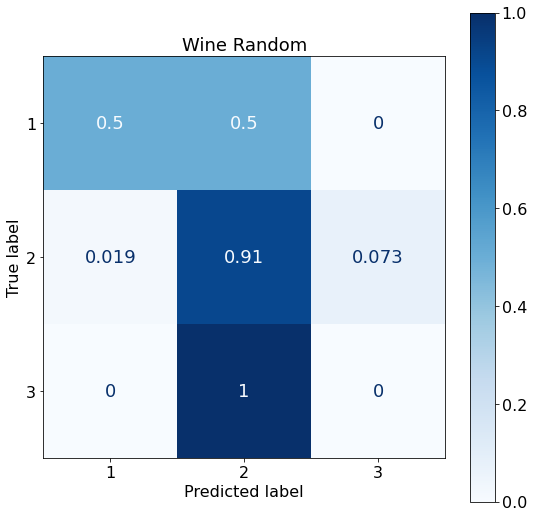

In [21]:
# Show confusion matrix
if plotConfusionR:
    with open(inTrialFileR, 'rb') as handle:
        allTemp = pickle.load(handle)
        bestA = allTemp[0]
        bestSpace = allTemp[1]
        allTrials = allTemp[2]
    
    bestTrial = allTrials.best_trial
    bestAcc = -bestTrial['result']['loss']
    print('Best Accuracy: {:.3f}'.format(bestAcc))
        
    bestVals = bestTrial['misc']['vals']
    bestRef = bestVals['classifier_type'][0]
    bestType = classifierList[bestRef]
    bestParams = {'classifier_type':bestRef}
    for key,val in bestVals.items():
        if bestType in key:
            bestParams.update({key:val[0]})
    bestParamSpace = space_eval(space, bestParams)
    print('Best Params: ', bestParamSpace)
        
    if confPNorm == None:
        strNorm = ''
    else:
        strNorm = confPNorm
    myFileR = dataSet + '_RConfusion' + strNorm + '.png'
    myTitle = dataSet + ' Random'
    y_Rpredict, y_Rtrue = testCLFP(bestParamSpace, pConf=True, 
                                   pSave=saveConfusionR,
                                   pFile=myFileR, pNorm=confPNorm,
                                   pTitle=myTitle)

### Compare Wine and Student Random Searches

In [22]:
compareWineStudentRandom = True
showTopRandomBoth = True
plotTopRandomBoth = True
saveTopRandomBoth = False
plotTopConfusionBoth = True
saveTopConfusionBoth = False

randomFileWine = './save/Wine_rTestResults100.pickle'
randomFileStudent = './save/Student_rTestResults100.pickle'

Wine Random Search Results


Wine_RTest  Wine_RTrain Wine_RType Wine_RTargs  Wine_RFeats  Wine_RNorm  \
73    0.588889     0.424875        gNB        BAG1            9           0   
77    0.588889     0.418449        gNB        BAG1            9           0   
83    0.571958     0.408098        gNB        BAG1            8           1   
72    0.552427     0.549741        gNB        BAG2           10           0   
93    0.541974     0.524622        gNB        BAG2            9           0   
..         ...          ...        ...         ...          ...         ...   
75    0.163802     0.196319        knn         All            7           1   
25    0.161152     0.164624        bNB         All            9           1   
32    0.161152     0.165855        bNB         All            7           0   
3     0.161152     0.168246        bNB         All            8           1   
2     0.159923     0.176953        gbc         All            8           0   

    Wine_RScale  
73            1  
77            1  
83            1  
72            0  
93            1  
..          ...  
75            0  
25            0  
32            0  
3             0  
2             0  

[100 rows x 7 columns]


Student Random Search Results


Student_RTest  Student_RTrain Student_RType  Student_RFeats  \
30       0.820076        0.819293        forest               3   
19       0.808712        0.810338           svm               3   
53       0.791212        0.823059           svm               7   
98       0.790985        0.745222           svm              19   
97       0.790909        0.792451           gbc              27   
..            ...             ...           ...             ...   
95       0.250000        0.250000           svm              18   
29       0.250000        0.316176           bNB               2   
57       0.250000        0.257585           svm              21   
1        0.226288        0.480656          tree               6   
89       0.075000        0.153898           svm               9   

    Student_RNorm  Student_RScale  
30              0               0  
19              0               0  
53              0               0  
98              0               1  
97              0               1  
..            ...             ...  
95              1               0  
29              0               0  
57              0               1  
1               1               1  
89              0               0  

[100 rows x 6 columns]



Top Wine Random Test Accuracy: 58.889
Top Wine Random Model: {'n_features': 9, 'n_targets': 'BAG1', 'normalize': 0, 'scale': 1, 'type': 'gNB', 'var_smoothing': 8.242630322348006e-09}

Top Student Random Test Accuracy: 82.008
Top Student Random Model: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'n_estimators': 171, 'n_features': 3, 'normalize': 0, 'scale': 0, 'type': 'forest'}



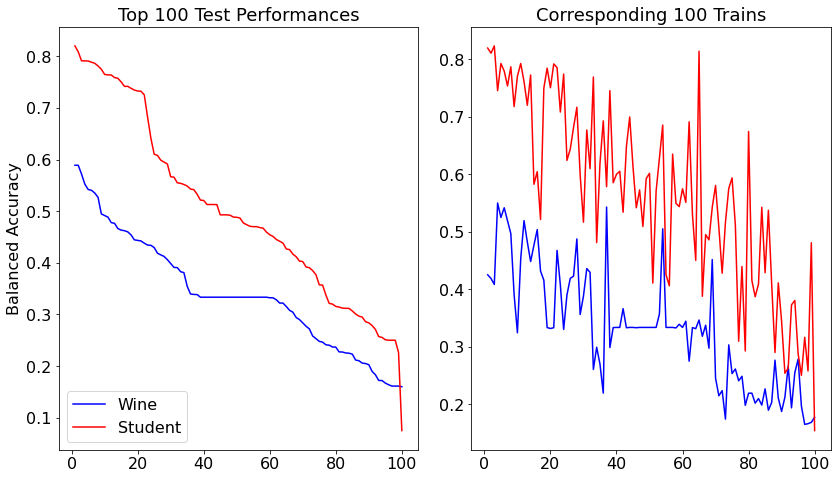

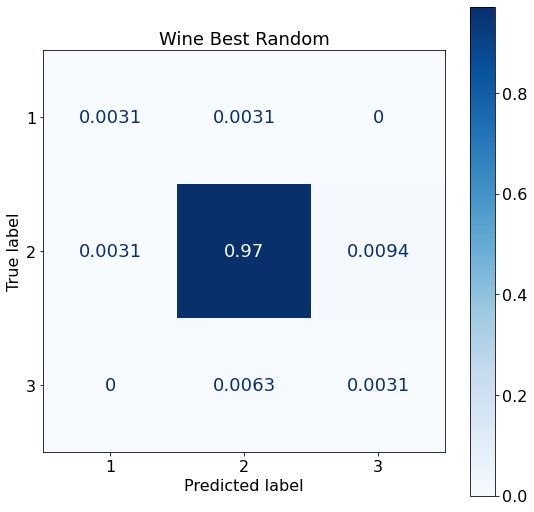

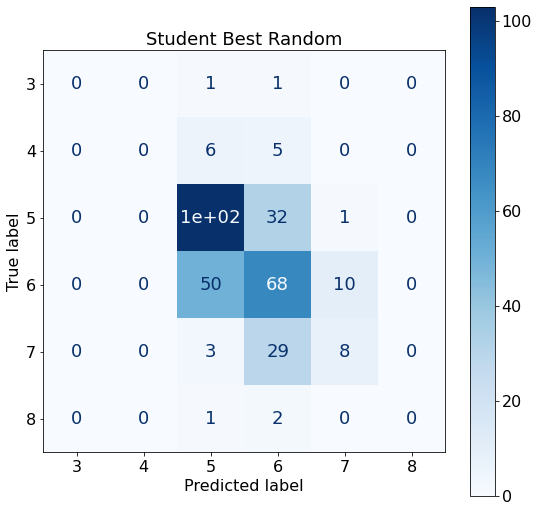

In [23]:
if compareWineStudentRandom:

    with open(randomFileWine,'rb') as handle:
        allTemp = pickle.load(handle)
        waccCV = allTemp[0]
        waccTrain = allTemp[1]
        waccTest = allTemp[2]
        wparamsSave = allTemp[3]
        
    with open(randomFileStudent,'rb') as handle:
        allTemp = pickle.load(handle)
        saccCV = allTemp[0]
        saccTrain = allTemp[1]
        saccTest = allTemp[2]
        sparamsSave = allTemp[3]

    # Report top models
    results = []
    topN = len(waccCV)
    for i in range(topN):
        wNow = wparamsSave[i]
        sNow = sparamsSave[i]

        results.append([waccCV[i],waccTest[i],saccCV[i],saccTest[i],
                        wNow['type'], wNow['n_targets'], wNow['n_features'],
                        wNow['normalize'], wNow['scale'],
                        sNow['type'], sNow['n_features'],
                        sNow['normalize'], sNow['scale']])
    
        dfResults = pandas.DataFrame(results, columns=[
                'Wine_RTrain','Wine_RTest', 
                'Student_RTrain','Student_RTest',
                'Wine_RType','Wine_RTargs','Wine_RFeats',
                'Wine_RNorm','Wine_RScale',
                'Student_RType','Student_RFeats',
                'Student_RNorm','Student_RScale'])
           
    if showTopRandomBoth:
        dfSubResultsG = dfResults.loc[:,['Wine_RTest','Wine_RTrain',
                        'Wine_RType','Wine_RTargs',
                        'Wine_RFeats','Wine_RNorm','Wine_RScale']]

        dfSubResultsGSort = dfSubResultsG.sort_values(by=['Wine_RTest'],ascending=False)
        print("Wine Random Search Results")
        display(dfSubResultsGSort)
        print()

        dfSubResultsR = dfResults.loc[:,['Student_RTest','Student_RTrain',
                                         'Student_RType','Student_RFeats',
                                         'Student_RNorm','Student_RScale']]
        dfSubResultsRSort = dfSubResultsR.sort_values(
            by=['Student_RTest'],ascending=False)
        print("Student Random Search Results")
        display(dfSubResultsRSort)
        print()
        
        waccTopSorted = [*waccTest.values()]
        waccTopSorted.sort()
        myTopWineRAcc = waccTopSorted[-1]
        for i in range(topN):
            for key,val in waccTest.items():
                if val == myTopWineRAcc: 
                    myTopWineRModel = wparamsSave[key]
        print()
        print("Top Wine Random Test Accuracy: {:.3f}".format(myTopWineRAcc*100.))
        print("Top Wine Random Model: {}".format(myTopWineRModel))

        saccTopSorted = [*saccTest.values()]
        saccTopSorted.sort()
        myTopStudentRAcc = saccTopSorted[-1]
        for i in range(topN): 
            for key,val in saccTest.items(): 
                if val == myTopStudentRAcc:
                    myTopStudentRModel = sparamsSave[key]
        print()
        print("Top Student Random Test Accuracy: {:.3f}".format(myTopStudentRAcc*100.))
        print("Top Student Random Model: {}".format(myTopStudentRModel))
        print()

    # Plot top accuracies
    if plotTopRandomBoth:
        fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12,7))
        xs = np.arange(1,topN+1,dtype=int)
        
        dfGResults = dfResults.loc[:,['Wine_RTest','Wine_RTrain']]
        dfGResults = dfGResults.sort_values(by=['Wine_RTest'],ascending=False)
        dfRResults = dfResults.loc[:,['Student_RTest','Student_RTrain']]
        dfRResults = dfRResults.sort_values(by=['Student_RTest'],ascending=False)
        
        axes[0].plot(xs,dfGResults['Wine_RTest'],color='b',label='Wine')
        axes[0].plot(xs,dfRResults['Student_RTest'],color='r',label='Student')
        axes[0].set_title('Top {} Test Performances'.format(topN))
        axes[0].set_ylabel('Balanced Accuracy')
        axes[0].legend(loc='lower left')

        axes[1].plot(xs,dfGResults['Wine_RTrain'],color='b',label='Wine')
        axes[1].plot(xs,dfRResults['Student_RTrain'],color='r',label='Student')
        axes[1].set_title('Corresponding {} Trains'.format(topN))
        fig.tight_layout()
        
        if saveTopRandomBoth:
            myFilename = 'random_top' + str(topN) + '_accuracy.png'
            plt.savefig(myFilename,bbox_inches='tight')
            
    # Show confusion matrix
    if plotTopConfusionBoth:
        myFileG = 'Wine_RConfusion.png'
        myTitle = 'Wine Best Random'
        y_Gpredict, y_Gtrue = testCLFP(myTopWineRModel, pConf=True, 
                                       pSave=saveTopConfusionBoth,
                                       pFile=myFileG, pNorm='all',
                                       pTitle=myTitle)
        
        myFileR = 'Student_RConfusion.png'
        myTitle = 'Student Best Random'
        y_Gpredict, y_Gtrue = testCLFP(myTopStudentRModel, pConf=True, 
                                       pSave=saveTopConfusionBoth,
                                       pFile=myFileR, pTitle=myTitle)

# 5 Guided Search: TPE

For guided search, Hyperopt implements the Tree-structured Parzen Estimator (TPE).  TPE is a sequential model-based optimization approach that sequentially constructs models to approximate the performance of hyperparameters based on historical measurements ([Claesen et al, 2014](https://optunity.readthedocs.io/en/latest/user/solvers/TPE.html#tpe2011)).

In [24]:
nGMaxEvals = 10
nPrintInfo = 2

guidedSearchHP = True
guidedSearchHPSave = False
guidedHPSaveFile = dataSet + '_gHPResults' + str(nGMaxEvals) + '.pickle'

In [25]:
# GUIDED SEARCH USING HYPEROPT TPE
if guidedSearchHP:
    print()
    countA = 0
    bestA = 0

    start_time = time.time()
    gTrials = Trials()
    bestGS = fmin(f, space, algo=tpe.suggest, max_evals=nGMaxEvals, 
                 trials=gTrials)
    bestGA = bestA
    bestGSpace = space_eval(space, bestGS)
    gTime = time.time() - start_time
    
    # Save results to pickle file
    if guidedSearchHPSave:
      with open(guidedHPSaveFile, 'wb') as handle:
            pickle.dump([bestGA, bestGSpace, gTrials, gTime], handle, 
                        protocol=pickle.HIGHEST_PROTOCOL)
    
    print('')
    print('--------------------------------------')
    print('Finished TPE Model Search in {:.3f}s'.format(gTime))
    print('Best Parameters: {}'.format(bestGSpace))
    print('Best CV Accuracy: {:.3f}'.format(bestGA*100.))
    print('Best Train Accuracy: {:.3f}'.format(
        hyperopt_train_test(bestGSpace.copy(), dUse='train')*100.)),
    print('Best Test Accuracy: {:.3f}'.format(
        hyperopt_train_test(bestGSpace.copy(), dUse='test')*100.))
    print('')
            


Count: 2, Accuracy: 19.79, Params: {'n_estimators': 59, 'n_features': 9, 'n_targets': 'All', 'normalize': 1, 'scale': 1, 'type': 'ada'}
Count: 4, Accuracy: 37.77, Params: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'n_estimators': 56, 'n_features': 9, 'n_targets': 'BAG1', 'normalize': 1, 'scale': 0, 'type': 'forest'}
Count: 6, Accuracy: 29.43, Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 113, 'n_features': 5, 'n_targets': 'All', 'normalize': 1, 'scale': 0, 'type': 'forest'}
Count: 8, Accuracy: 20.70, Params: {'C': 1.3491255677360925, 'degree': 3, 'kernel': 'poly', 'n_features': 4, 'n_targets': 'All', 'normalize': 1, 'scale': 0, 'type': 'svm'}
Count: 10, Accuracy: 37.80, Params: {'algorithm': 'brute', 'leaf_size': 6, 'n_features': 10, 'n_neighbors': 15, 'n_targets': 'BAG1', 'normalize': 0, 'scale': 0, 'type': 'knn', 'weights': 'distance'}
100%|██████████| 10/10 [00:04<00:00,  2.15trial/s, best loss: -0.37797619047619047]

--

### Calculate Guided Search Test Accuracies
To investigate the guided search, calculate the performance of all trials from a saved guided search on the test dataset. This will save the output into another pickle file containing the training and testing output that can be used to create plots and tables.

In [26]:
calcTestAccuracyG = False

printNCheckG = 20
inTrialFileG = './save/' + dataSet + '_gHPResults100.pickle'
saveTestFileG = './save/' + dataSet + '_gTestResults100.pickle'

In [30]:
# Open Guided Trial Results and Save Test Results
if calcTestAccuracyG:
    with open(inTrialFileG, 'rb') as handle:
        allTemp = pickle.load(handle)
        bestA = allTemp[0]
        bestSpace = allTemp[1]
        allTrials = allTemp[2]
    
    accCV = {}
    accTrain = {}
    accTest = {}
    paramsSave = {}
    count = 0
    for mt in allTrials.trials:
        accHere = -mt['result']['loss']
        valsHere = mt['misc']['vals']
        typeRef = valsHere['classifier_type'][0]
        typeHere = classifierList[typeRef]
        paramsHere = {'classifier_type':typeRef}
        for key,val in valsHere.items():
            if typeHere in key:
                paramsHere.update({key:val[0]})
        paramsSpace = space_eval(space, paramsHere)
        paramsSave.update({count:paramsSpace})
        accCV[count] = hyperopt_train_test(
            paramsSpace.copy(),dUse='cv')
        accTrain[count] = hyperopt_train_test(
            paramsSpace.copy(),dUse='train')
        accTest[count] = hyperopt_train_test(
            paramsSpace.copy(),dUse='test')
        
        count += 1
        if ((count % printNCheckG) == 0):
           print('Iter {}: Acc O= {:.3f}, CV= {:.3f}, Train= {:.3f}, Test= {:.3f}'.
                  format(count, accHere, accCV[count-1], accTrain[count-1], 
                         accTest[count-1]))
  
    with open(saveTestFilenameG, 'wb') as handle:
          pickle.dump([accCV, accTrain, accTest, paramsSave],
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Created File: ',saveTestFileG)
    


### Plot Guided Confusion Matrix

In [33]:
plotConfusionG = True
saveConfusionG = False

confPNorm = 'true'
inTrialFileG = './save/' + dataSet + '_gHPResults100.pickle'

Best Accuracy: 0.586
Best Params:  {'n_features': 10, 'n_targets': 'BAG2', 'normalize': 0, 'scale': 1, 'type': 'gNB', 'var_smoothing': 3.5886019462968592e-09}


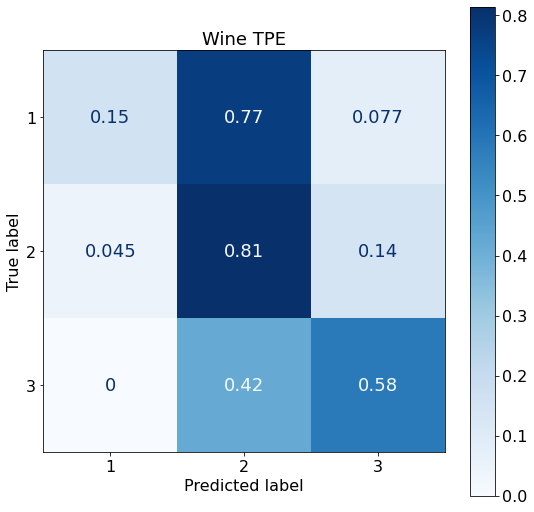

In [34]:
# Show confusion matrix
if plotConfusionG:
    with open(inTrialFileG, 'rb') as handle:
        allTemp = pickle.load(handle)
        bestA = allTemp[0]
        bestSpace = allTemp[1]
        allTrials = allTemp[2]
    
    bestTrial = allTrials.best_trial
    bestAcc = -bestTrial['result']['loss']
    print('Best Accuracy: {:.3f}'.format(bestAcc))
        
    bestVals = bestTrial['misc']['vals']
    bestRef = bestVals['classifier_type'][0]
    bestType = classifierList[bestRef]
    bestParams = {'classifier_type':bestRef}
    for key,val in bestVals.items():
        if bestType in key:
            bestParams.update({key:val[0]})
    bestParamSpace = space_eval(space, bestParams)
    print('Best Params: ', bestParamSpace)
        
    if confPNorm == None:
        strNorm = ''
    else:
        strNorm = confPNorm
    myFileG = dataSet + '_GConfusion' + strNorm + '.png'
    myTitle = dataSet + ' TPE'
    y_Gpredict, y_Gtrue = testCLFP(bestParamSpace, pConf=True, 
                                   pSave=saveConfusionG,
                                   pFile=myFileG, pNorm=confPNorm,
                                   pTitle=myTitle)

### Compare Wine and Student Guided Searches

In [35]:
compareWineStudentGuided = True
showTopGuidedBoth = True
plotTopGuidedBoth = True
saveTopGuidedBoth = False

guidedFileWine = './save/Wine_gTestResults100.pickle'
guidedFileStudent = './save/Student_gTestResults100.pickle'
randomFileWine = './save/Wine_rTestResults100.pickle'
randomFileStudent = './save/Student_rTestResults100.pickle'

Wine Guided Search Results


Wine_GTest  Wine_GTrain Wine_GType Wine_GTargs  Wine_GFeats  Wine_GNorm  \
38    0.580277     0.535942        gNB        BAG2            8           0   
91    0.570316     0.541552        gNB        BAG2           10           0   
42    0.566000     0.491885       tree        BAG2            9           0   
78    0.564003     0.536763        gNB        BAG2            9           0   
44    0.564003     0.517618        gNB        BAG2            9           0   
..         ...          ...        ...         ...          ...         ...   
32    0.166667     0.166667        bNB         All            4           1   
61    0.166667     0.166667        bNB         All            3           0   
4     0.166513     0.198533        svm         All            5           0   
90    0.153493     0.219010        svm         All            7           1   
11    0.147733     0.212744       tree         All            7           1   

    Wine_GScale  
38            1  
91            0  
42            1  
78            1  
44            1  
..          ...  
32            0  
61            0  
4             0  
90            1  
11            0  

[100 rows x 7 columns]


Student Guided Search Results


Student_GTest  Student_GTrain Student_GType  Student_GFeats  \
67       0.842348        0.798509        forest              16   
62       0.834242        0.807089        forest              25   
90       0.822879        0.749800        forest              14   
68       0.821515        0.798259        forest              16   
39       0.820076        0.797995        forest               8   
..            ...             ...           ...             ...   
94       0.261061        0.407883           bNB              29   
57       0.250000        0.296576           svm              19   
51       0.250000        0.316483           bNB               2   
44       0.250000        0.250000           svm              13   
0        0.243561        0.298408           gbc              26   

    Student_GNorm  Student_GScale  
67              0               1  
62              0               1  
90              0               1  
68              0               1  
39              0               1  
..            ...             ...  
94              1               0  
57              1               0  
51              0               0  
44              0               0  
0               0               0  

[100 rows x 6 columns]



Top Wine Guided Test Accuracy: 58.028
Top Wine Guided Model: {'n_features': 8, 'n_targets': 'BAG2', 'normalize': 0, 'scale': 1, 'type': 'gNB', 'var_smoothing': 5.852077042745424e-09}

Top Student Guided Test Accuracy: 84.235
Top Student Guided Model: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 120, 'n_features': 16, 'normalize': 0, 'scale': 1, 'type': 'forest'}



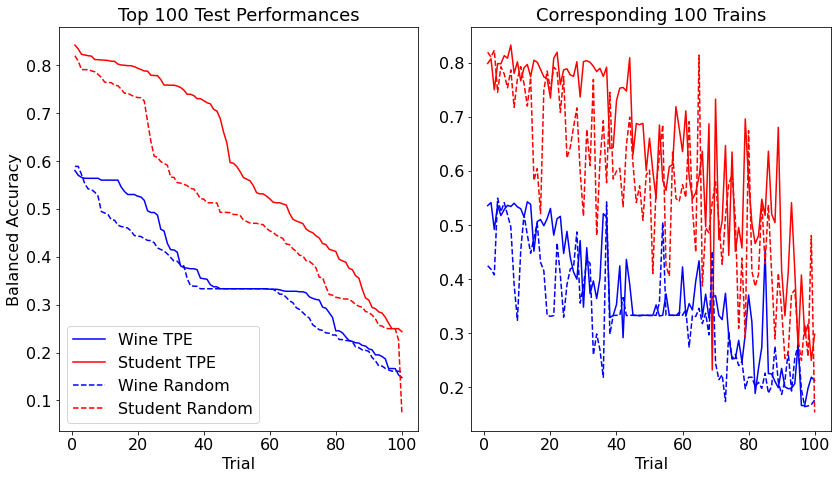

In [36]:
if compareWineStudentGuided:

    with open(guidedFileWine,'rb') as handle:
        allTemp = pickle.load(handle)
        waccCV = allTemp[0]
        waccTrain = allTemp[1]
        waccTest = allTemp[2]
        wparamsSave = allTemp[3]
        
    with open(guidedFileStudent,'rb') as handle:
        allTemp = pickle.load(handle)
        saccCV = allTemp[0]
        saccTrain = allTemp[1]
        saccTest = allTemp[2]
        sparamsSave = allTemp[3]

    with open(randomFileWine,'rb') as handle:
        allTempR = pickle.load(handle)
        waccCVR = allTempR[0]
        waccTrainR = allTempR[1]
        waccTestR = allTempR[2]
        wparamsSaveR = allTempR[3]
        
    with open(randomFileStudent,'rb') as handle:
        allTempR = pickle.load(handle)
        saccCVR = allTempR[0]
        saccTrainR = allTempR[1]
        saccTestR = allTempR[2]
        sparamsSaveR = allTempR[3]
        
    # Report top models
    results = []
    resultsR = []
    topN = len(waccCVR)
    for i in range(topN):
        wNow = wparamsSave[i]
        sNow = sparamsSave[i]
        
        results.append([waccCV[i],waccTest[i],saccCV[i],saccTest[i],
                        wNow['type'], wNow['n_targets'], wNow['n_features'],
                        wNow['normalize'], wNow['scale'],
                        sNow['type'], sNow['n_features'],
                        sNow['normalize'], sNow['scale']])
    
        dfResults = pandas.DataFrame(results, columns=[
                'Wine_GTrain','Wine_GTest', 
                'Student_GTrain','Student_GTest',
                'Wine_GType','Wine_GTargs','Wine_GFeats',
                'Wine_GNorm','Wine_GScale',
                'Student_GType','Student_GFeats',
                'Student_GNorm','Student_GScale'])
        
        wNowR = wparamsSaveR[i]
        sNowR = sparamsSaveR[i]
           
        resultsR.append([waccCVR[i],waccTestR[i],saccCVR[i],saccTestR[i],
                    wNowR['type'], wNowR['n_targets'], wNow['n_features'],
                    wNowR['normalize'], wNowR['scale'],
                    sNowR['type'], sNowR['n_features'],
                    sNowR['normalize'], sNowR['scale']])
    
        dfResultsR = pandas.DataFrame(resultsR, columns=[
                'Wine_RTrain','Wine_RTest', 
                'Student_RTrain','Student_RTest',
                'Wine_RType','Wine_RTargs','Wine_RFeats',
                'Wine_RNorm','Wine_RScale',
                'Student_RType','Student_RFeats',
                'Student_RNorm','Student_RScale'])
            
    if showTopGuidedBoth:
        dfSubResultsG = dfResults.loc[:,['Wine_GTest','Wine_GTrain',
                        'Wine_GType','Wine_GTargs',
                        'Wine_GFeats','Wine_GNorm','Wine_GScale']]

        dfSubResultsGSort = dfSubResultsG.sort_values(by=['Wine_GTest'],ascending=False)
        print("Wine Guided Search Results")
        display(dfSubResultsGSort)
        print()

        dfSubResultsR = dfResults.loc[:,['Student_GTest','Student_GTrain',
                                         'Student_GType','Student_GFeats',
                                         'Student_GNorm','Student_GScale']]
        dfSubResultsRSort = dfSubResultsR.sort_values(
            by=['Student_GTest'],ascending=False)
        print("Student Guided Search Results")
        display(dfSubResultsRSort)
        print()
        
        waccTopSorted = [*waccTest.values()]
        waccTopSorted.sort()
        myTopWineGAcc = waccTopSorted[-1]
        for i in range(topN):
            for key,val in waccTest.items():
                if val == myTopWineGAcc: 
                    myTopWineGModel = wparamsSave[key]
        print()
        print("Top Wine Guided Test Accuracy: {:.3f}".format(myTopWineGAcc*100.))
        print("Top Wine Guided Model: {}".format(myTopWineGModel))

        saccTopSorted = [*saccTest.values()]
        saccTopSorted.sort()
        myTopStudentGAcc = saccTopSorted[-1]
        for i in range(topN): 
            for key,val in saccTest.items(): 
                if val == myTopStudentGAcc:
                    myTopStudentGModel = sparamsSave[key]
        print()
        print("Top Student Guided Test Accuracy: {:.3f}".format(myTopStudentGAcc*100.))
        print("Top Student Guided Model: {}".format(myTopStudentGModel))
        print()

    # Plot top accuracies
    if plotTopGuidedBoth:
        fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12,7))
        xs = np.arange(1,topN+1,dtype=int)
        
        dfGResults = dfResults.loc[:,['Wine_GTest','Wine_GTrain']]
        dfGResults = dfGResults.sort_values(by=['Wine_GTest'],ascending=False)
        dfRResults = dfResults.loc[:,['Student_GTest','Student_GTrain']]
        dfRResults = dfRResults.sort_values(by=['Student_GTest'],ascending=False)
        dfGResultsR = dfResultsR.loc[:,['Wine_RTest','Wine_RTrain']]
        dfGResultsR = dfGResultsR.sort_values(by=['Wine_RTest'],ascending=False)
        dfRResultsR = dfResultsR.loc[:,['Student_RTest','Student_RTrain']]
        dfRResultsR = dfRResultsR.sort_values(by=['Student_RTest'],ascending=False)
        
        axes[0].plot(xs,dfGResults['Wine_GTest'],color='b',label='Wine TPE')
        axes[0].plot(xs,dfRResults['Student_GTest'],color='r',label='Student TPE')
        axes[0].plot(xs,dfGResultsR['Wine_RTest'],color='b',label='Wine Random',
                    linestyle='dashed')
        axes[0].plot(xs,dfRResultsR['Student_RTest'],color='r', label='Student Random',
                    linestyle='dashed')
        
        axes[0].set_title('Top {} Test Performances'.format(topN))
        axes[0].set_xlabel('Trial')
        axes[0].set_ylabel('Balanced Accuracy')
        axes[0].legend(loc='lower left')

        axes[1].plot(xs,dfGResults['Wine_GTrain'],color='b',label='Wine TPE')
        axes[1].plot(xs,dfRResults['Student_GTrain'],color='r',label='Student TPE')
        axes[1].plot(xs,dfGResultsR['Wine_RTrain'],color='b',label='Wine Random',
                    linestyle='dashed')
        axes[1].plot(xs,dfRResultsR['Student_RTrain'],color='r',label='Student Random',
                    linestyle='dashed')
        axes[1].set_title('Corresponding {} Trains'.format(topN))
        axes[1].set_xlabel('Trial')
        fig.tight_layout()
        
        if saveTopGuidedBoth:
            myFilename = 'guided_top' + str(topN) + '_accuracy.png'
            plt.savefig(myFilename,bbox_inches='tight')

# 6 Model Comparison

### Single Comparisons
Model comparisons are done for a set number of trials for both the random and guided search, and results are shown in tables and figures.  Currently the top 10 models from both the random and guided search are being investigated; however, this can be changed by altering the topN parameter below.

In [37]:
topN = 10
compareResults = True
plotTopAccuracies = True
saveTopAccuracies = False
showTopModels = True
saveTopModels = False
plotTopConfusion = True
saveTopConfusion = False

gHPSaveFile = './save/' + dataSet + '_gHPResults100.pickle'
rHPSaveFile = './save/' + dataSet + '_rHPResults100.pickle'

Guided Search Results


G_Test   G_Train G_Type G_Targs  G_Feats  G_Norm  G_Scale
0  0.516545  0.557589    gNB    BAG2       10       0        1
1  0.516545  0.523654    gNB    BAG2       10       0        1
4  0.516545  0.544592    gNB    BAG2       10       0        1
7  0.516545  0.519516    gNB    BAG2       10       0        1
9  0.516193  0.507589    gNB    BAG2        8       0        1
2  0.491991  0.546211    gNB    BAG2        9       0        1
3  0.491991  0.538626    gNB    BAG2        9       0        1
5  0.491991  0.516601    gNB    BAG2        9       0        1
6  0.491991  0.525932    gNB    BAG2        9       0        1
8  0.491991  0.518869    gNB    BAG2        9       0        1


Random Search Results


R_Test   R_Train  R_Type R_Targs  R_Feats  R_Norm  R_Scale
8  0.606878  0.363057     gNB    BAG1        9       0        1
7  0.568737  0.524003     gNB    BAG2        6       0        0
5  0.546884  0.520193     gNB    BAG2        6       0        1
1  0.540924  0.531916     gNB    BAG2       10       0        0
2  0.491991  0.526815     gNB    BAG2        9       0        1
6  0.485501  0.485104    tree    BAG2       10       0        1
9  0.475922  0.485325  forest    BAG2        6       0        1
0  0.469312  0.536074     gNB    BAG1        8       1        1
3  0.362873  0.446428     ada    BAG2        5       0        1
4  0.333333  0.518859     gNB    BAG2        5       0        0



Top Guided Test Accuracy: 51.655
Top Guided Model: {'n_features': 10, 'n_targets': 'BAG2', 'normalize': 0, 'scale': 1, 'type': 'gNB', 'var_smoothing': 4.52459353603048e-09}

Top Random Test Accuracy: 60.688
Top Random Model: {'n_features': 9, 'n_targets': 'BAG1', 'normalize': 0, 'scale': 1, 'type': 'gNB', 'var_smoothing': 4.598155839236196e-10}



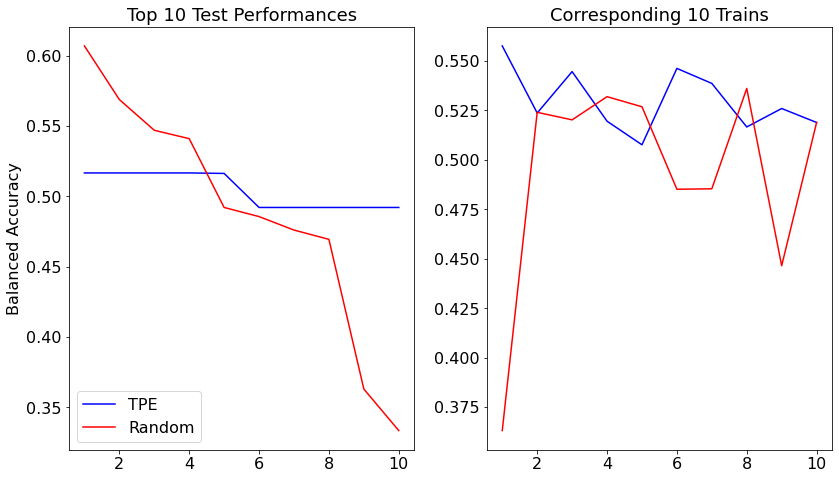

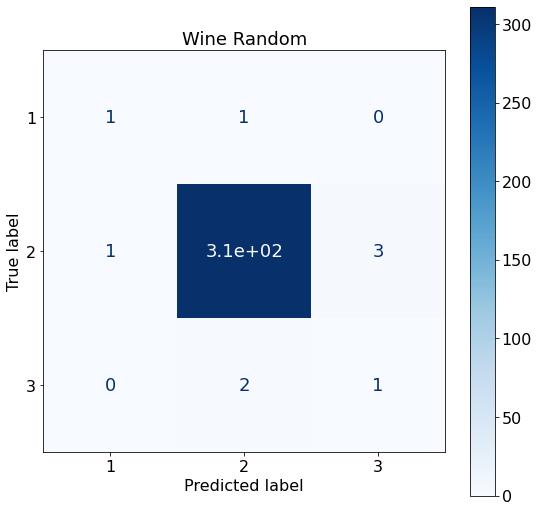

In [38]:
# COMPARE TEST ACCURACIES
if compareResults:

    # Open HP Guided Results from pickle files
    with open(gHPSaveFile, 'rb') as handle:
           allTemp = pickle.load(handle)
           bestGA = allTemp[0]
           bestGSpace = allTemp[1]
           gTrials = allTemp[2]
           gTime = allTemp[3]
           
    # Open HP Random Results from pickle files
    with open(rHPSaveFile, 'rb') as handle:
           allTemp = pickle.load(handle)
           bestRA = allTemp[0]
           bestRSpace = allTemp[1]
           rTrials = allTemp[2]
           rTime = allTemp[3]
           
    # Plot top 5 accuracies per method
    raccAll = np.sort([-t['result']['loss'] for t in rTrials.trials])[::-1]
    gaccAll = np.sort([-t['result']['loss'] for t in gTrials.trials])[::-1]
    
    gaccCV = {}
    gaccTrain = {}
    gaccTest = {}
    gparamsSave = {}
    for i in range(topN):
        for g in gTrials.trials:
           accHere = -g['result']['loss']
           valsHere = g['misc']['vals']
    
           if accHere == gaccAll[i]:
              typeRef = valsHere['classifier_type'][0]
              typeHere = classifierList[typeRef]
              paramsHere = {'classifier_type':typeRef}
              for key,val in valsHere.items():
                  if typeHere in key:
                      paramsHere.update({key:val[0]})
              paramsSpace = space_eval(space, paramsHere)
              gparamsSave.update({i:paramsSpace})
              gaccCV[i] = hyperopt_train_test(
                  paramsSpace.copy(),dUse='cv')
              gaccTrain[i] = hyperopt_train_test(
                  paramsSpace.copy(),dUse='train')
              gaccTest[i] = hyperopt_train_test(
                  paramsSpace.copy(),dUse='test')
  
    raccCV = {}
    raccTrain = {}
    raccTest = {}
    rparamsSave = {}
    for i in range(topN):
         for r in rTrials.trials:
            accHere = -r['result']['loss']
            valsHere = r['misc']['vals']
    
            if accHere == raccAll[i]:
               typeRef = valsHere['classifier_type'][0]
               typeHere = classifierList[typeRef]
               paramsHere = {'classifier_type':typeRef}
               for key,val in valsHere.items():
                   if typeHere in key:
                       paramsHere.update({key:val[0]})
               paramsSpace = space_eval(space, paramsHere)
               rparamsSave.update({i:paramsSpace})
               raccCV[i] = hyperopt_train_test(
                  paramsSpace.copy(),dUse='cv')
               raccTrain[i] = hyperopt_train_test(
                  paramsSpace.copy(),dUse='train')
               raccTest[i] = hyperopt_train_test(
                  paramsSpace.copy(),dUse='test')               

    # Report top models
    if showTopModels:
       results = []
       for i in range(topN):
           gNow = gparamsSave[i]
           rNow = rparamsSave[i]
           if dataSet == 'Wine':
              results.append([gaccCV[i],gaccTest[i],raccCV[i],raccTest[i],
                           gNow['type'], gNow['n_targets'], gNow['n_features'],
                           gNow['normalize'], gNow['scale'],
                           rNow['type'], rNow['n_targets'], rNow['n_features'],
                           rNow['normalize'], rNow['scale']])
              
              dfResults = pandas.DataFrame(results, columns=[
                      'G_Train','G_Test', 'R_Train','R_Test',
                      'G_Type','G_Targs','G_Feats',
                      'G_Norm','G_Scale',
                      'R_Type','R_Targs','R_Feats',
                      'R_Norm','R_Scale'])
           elif dataSet == 'Student':
               results.append([gaccCV[i],gaccTest[i],raccCV[i],raccTest[i],
                           gNow['type'], gNow['n_features'],
                           gNow['normalize'], gNow['scale'],
                           rNow['type'], rNow['n_features'],
                           rNow['normalize'], rNow['scale']])
    
               dfResults = pandas.DataFrame(results, columns=[
                      'G_Train','G_Test', 'R_Train','R_Test',
                      'G_Type','G_Feats',
                      'G_Norm','G_Scale',
                      'R_Type','R_Feats',
                      'R_Norm','R_Scale'])
       
       if saveTopModels:
           myFilename = dataSet + '_top' + str(topN) + 'models.pickle'
           dfResults.to_pickle(myFilename)
             
       # Print Top Stats
       #display(dfResults.sort_values(by=['G_Test'],ascending=False))
       dfSubResults = dfResults.loc[:,['G_Test','R_Test','G_Type','R_Type']]
       dfSubResultsSort = dfSubResults.sort_values(
           by=['G_Test'],ascending=False)
       #print(dfSubResultsSort)
       #display(dfSubResultsSort)
       #print()
       
       if dataSet == 'Wine':
          dfSubResultsG = dfResults.loc[:,['G_Test','G_Train','G_Type','G_Targs',
                                        'G_Feats','G_Norm','G_Scale']]
       elif dataSet == 'Student':
           dfSubResultsG = dfResults.loc[:,['G_Test','G_Train','G_Type',
                                        'G_Feats','G_Norm','G_Scale']]
       dfSubResultsGSort = dfSubResultsG.sort_values(by=['G_Test'],ascending=False)
       #print(dfSubResultsGSort)
       print("Guided Search Results")
       display(dfSubResultsGSort)
       print()
       
       if dataSet == 'Wine':
          dfSubResultsR = dfResults.loc[:,['R_Test','R_Train','R_Type','R_Targs',
                                        'R_Feats','R_Norm','R_Scale']]
       elif dataSet == 'Student':
          dfSubResultsR = dfResults.loc[:,['R_Test','R_Train','R_Type',
                                        'R_Feats','R_Norm','R_Scale']]
       dfSubResultsRSort = dfSubResultsR.sort_values(
           by=['R_Test'],ascending=False)
       #print(dfSubResultsRSort)
       print("Random Search Results")
       display(dfSubResultsRSort)
       print()
       
       gaccTopSorted = [*gaccTest.values()]
       gaccTopSorted.sort()
       myTopGAcc = gaccTopSorted[-1]
       for i in range(topN):
          for key,val in gaccTest.items():
             if val == myTopGAcc:
                 myTopGModel = gparamsSave[key]
       print()
       print("Top Guided Test Accuracy: {:.3f}".format(myTopGAcc*100.))
       print("Top Guided Model: {}".format(myTopGModel))

       raccTopSorted = [*raccTest.values()]
       raccTopSorted.sort()
       myTopRAcc = raccTopSorted[-1]
       for i in range(topN):
          for key,val in raccTest.items():
             if val == myTopRAcc:
                 myTopRModel = rparamsSave[key]
       print()
       print("Top Random Test Accuracy: {:.3f}".format(myTopRAcc*100.))
       print("Top Random Model: {}".format(myTopRModel))
       print()

    # Plot top accuracies
    if plotTopAccuracies:
       fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12,7))
       xs = np.arange(1,topN+1,dtype=int)
    
       dfGResults = dfResults.loc[:,['G_Test','G_Train']]
       dfGResults = dfGResults.sort_values(by=['G_Test'],ascending=False)
       dfRResults = dfResults.loc[:,['R_Test','R_Train']]
       dfRResults = dfRResults.sort_values(by=['R_Test'],ascending=False)
       
       axes[0].plot(xs,dfGResults['G_Test'],color='b',label='TPE')
       axes[0].plot(xs,dfRResults['R_Test'],color='r',label='Random')
       axes[0].set_title('Top {} Test Performances'.format(topN))
       axes[0].set_ylabel('Balanced Accuracy')
       axes[0].legend(loc='lower left')

       axes[1].plot(xs,dfGResults['G_Train'],color='b',label='TPE')
       axes[1].plot(xs,dfRResults['R_Train'],color='r',label='Random')
       axes[1].set_title('Corresponding {} Trains'.format(topN))
       fig.tight_layout()
    
       if saveTopAccuracies:
          myFilename = dataSet + '_top' + str(topN) + 'accuracy.png'
          plt.savefig(myFilename,bbox_inches='tight')
            
    # Show confusion matrix
    if plotTopConfusion:
        #print('Guided Confusion Matrix')
        myFileG =  dataSet + '_Gconfusion.png'
        myTitle = dataSet + ' Guided'
        y_Gpredict, y_Gtrue = testCLFP(myTopGModel, pConf=True, 
                                       pSave=saveTopConfusion,
                                       pFile=myFileG, 
                                       pTitle=myTitle)
        
        #print('Random Confusion Matrix')
        myFileR =  dataSet + '_Rconfusion.png'
        myTitle = dataSet + ' Random'
        y_Gpredict, y_Gtrue = testCLFP(myTopRModel, pConf=True, 
                                       pSave=saveTopConfusion,
                                       pFile=myFileR,
                                       pTitle=myTitle)

### Multi-Comparisons
Comparisons are also done showing the impact of changing the number of tests/evaluations to perform per random/guided individual search.

In [39]:
topN = 10
compareMultiResults = True
calcMultiResults = False
saveMultiResults = False
showMultiTopModels = True
saveMultiTopModels = False
plotMultiTopAccuracies = True
saveMultiTopAccuracies = False

if dataSet == 'Student':
   nMultiEvals = [10,50,100,150,200,250,300]
   linesS = [(0, (1, 1)), (0, (3, 1, 1, 1)), (0, (3, 1, 1, 1, 1, 1)), 
             (0, (3, 5, 1, 5, 1, 5)), (0, (3, 5, 1, 5)), 
             (0, (5, 5)), (0, ())]
else:
   nMultiEvals = [10, 100, 300, 500]
   linesS = [(0, (1, 1)), (0, (3, 1, 1, 1, 1, 1)), 
             (0, (3, 5, 1, 5, 1, 5)), (0, ())]




Guided Search Results


G_Test   G_Train G_Type G_Targs  G_Feats  G_Norm  G_Scale  nEval
29  0.582003  0.548970    ada    BAG2        9       0        0    300
21  0.576952  0.514113    ada    BAG2        9       0        0    300
19  0.575403  0.530633    gNB    BAG2        8       0        1    100
24  0.564884  0.512736    ada    BAG2        9       0        0    300
23  0.556186  0.517447    ada    BAG2        9       0        0    300
25  0.555804  0.523248    ada    BAG2        9       0        0    300
27  0.549938  0.491741    ada    BAG2        9       0        0    300
26  0.540086  0.563312    ada    BAG2        8       0        0    300
17  0.536013  0.559404    gNB    BAG2       10       0        1    100
10  0.536013  0.544159    gNB    BAG2       10       0        1    100
11  0.536013  0.538696    gNB    BAG2       10       0        1    100
14  0.536013  0.545393    gNB    BAG2       10       0        1    100
37  0.532225  0.554667    gNB    BAG2       10       0        0    500
35  0.532225  0.575535    gNB    BAG2       10       0        0    500
20  0.519364  0.536928    ada    BAG2        9       0        0    300
0   0.435202  0.566559    ada    BAG2        7       0        1     10
1   0.423802  0.463530   tree    BAG2        9       0        1     10
16  0.418575  0.555537    gNB    BAG2        9       0        1    100
18  0.418575  0.535860    gNB    BAG2        9       0        1    100
13  0.418575  0.565103    gNB    BAG2        9       0        1    100
12  0.418575  0.538967    gNB    BAG2        9       0        1    100
22  0.418575  0.544727    gNB    BAG2        9       0        1    300
36  0.418575  0.540991    gNB    BAG2        9       0        1    500
15  0.418575  0.551708    gNB    BAG2        9       0        1    100
2   0.341261  0.467770    bNB    BAG2        5       0        1     10
31  0.333333  0.560037    gNB    BAG2        9       0        0    500
38  0.333333  0.545413    gNB    BAG2        9       0        0    500
3   0.333333  0.330679    ada    BAG1        3       0        0     10
34  0.333333  0.549587    gNB    BAG2        9       0        0    500
33  0.333333  0.551470    gNB    BAG2        9       0        0    500
32  0.333333  0.549220    gNB    BAG2        9       0        0    500
39  0.333333  0.517054    gNB    BAG2        9       0        0    500
30  0.333333  0.530245    gNB    BAG2        9       0        0    500
5   0.333333  0.333333    knn    BAG1        9       1        0     10
6   0.333333  0.333333    knn    BAG1        9       1        0     10
7   0.333333  0.331741    gNB    BAG1        3       1        0     10
28  0.324786  0.509690    ada    BAG2        4       0        0    300
4   0.316102  0.339193    gbc    BAG2        2       0        0     10
8   0.308856  0.291969    gbc     All       10       0        1     10
9   0.239445  0.227116   tree     All        3       0        0     10


Random Search Results


R_Test   R_Train  R_Type R_Targs  R_Feats  R_Norm  R_Scale  nEval
27  0.584806  0.555007     ada    BAG2        8       0        1    300
31  0.576218  0.533361     ada    BAG2        9       0        0    500
22  0.575403  0.551207     gNB    BAG2        8       0        1    300
32  0.556714  0.525716     ada    BAG2        9       0        0    500
20  0.546575  0.504120     ada    BAG2        8       0        1    300
34  0.543654  0.512879     gbc    BAG2        8       0        1    500
11  0.532225  0.536444     gNB    BAG2       10       0        0    100
30  0.520581  0.504524     ada    BAG2       10       0        0    500
16  0.519981  0.479163    tree    BAG2       10       0        1    100
24  0.515877  0.532316     ada    BAG2       10       0        0    300
35  0.511142  0.535980     gNB    BAG2        8       0        0    500
36  0.460847  0.587276     gNB    BAG1       10       1        0    500
10  0.458730  0.552605     gNB    BAG1        8       1        1    100
21  0.448709  0.590323     ada    BAG2        7       0        1    300
39  0.446461  0.527786     gNB    BAG2        9       1        1    500
23  0.439694  0.503404     ada    BAG2        7       0        1    300
12  0.418575  0.557509     gNB    BAG2        9       0        1    100
1   0.414993  0.437515     knn    BAG2        8       0        1     10
13  0.412820  0.519914     ada    BAG2        5       0        1    100
25  0.407489  0.454586    tree    BAG2        6       0        0    300
17  0.402082  0.525387     gNB    BAG2        6       0        0    100
15  0.380197  0.533658     gNB    BAG2        6       0        1    100
26  0.380197  0.522848     gNB    BAG2        6       0        1    300
29  0.350981  0.533731     ada    BAG2        4       0        1    300
19  0.346312  0.455724  forest    BAG2        6       0        1    100
38  0.345862  0.574541     ada    BAG2        5       0        0    500
0   0.337297  0.430812     knn    BAG2        5       1        1     10
14  0.333333  0.532360     gNB    BAG2        5       0        0    100
28  0.333333  0.528070     gNB    BAG2        9       1        0    300
5   0.333333  0.366242     gNB    BAG1        3       0        0     10
33  0.333333  0.559376     gNB    BAG2        9       0        0    500
37  0.333333  0.546205     gNB    BAG2        7       0        0    500
18  0.326984  0.464892     gNB    BAG1        9       0        1    100
4   0.325926  0.372877     ada    BAG1        5       1        1     10
6   0.311986  0.379752     gbc    BAG2        2       0        0     10
2   0.223652  0.307991  forest     All        5       0        0     10
3   0.195267  0.307207     knn     All        5       0        1     10
8   0.172580  0.287648    tree     All        6       1        1     10
7   0.166667  0.256830    tree     All        6       0        0     10
9   0.154795  0.175498     svm     All        2       0        0     10



Top Guided Test Accuracy: 58.200
Top Guided Model: {'n_estimators': 68, 'n_features': 9, 'n_targets': 'BAG2', 'normalize': 0, 'scale': 0, 'type': 'ada'}

Top Random Test Accuracy: 58.481
Top Random Model: {'n_estimators': 71, 'n_features': 8, 'n_targets': 'BAG2', 'normalize': 0, 'scale': 1, 'type': 'ada'}



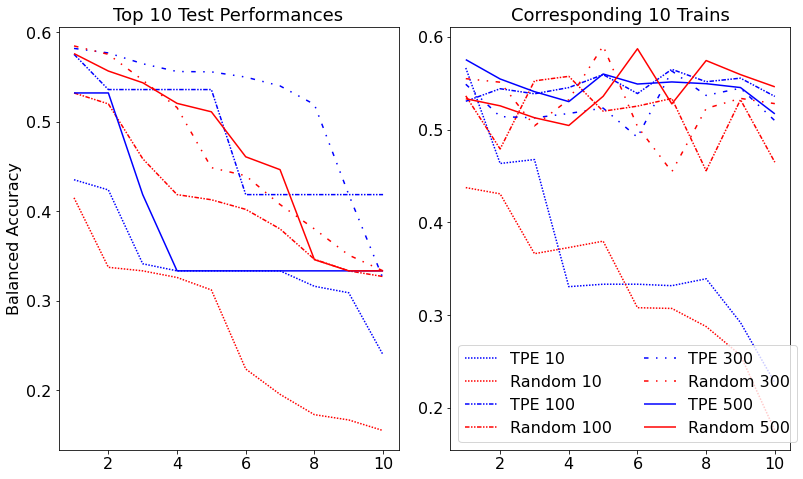

In [40]:
# COMPARE Multiple TEST ACCURACIES
if compareMultiResults:

    if calcMultiResults:
       gaccCVAll = {}
       gaccTrainAll = {}
       gaccTestAll = {}
       gparamsSaveAll = {}
       raccCVAll = {}
       raccTrainAll = {}
       raccTestAll = {}
       rparamsSaveAll = {}

       for imulti in nMultiEvals:
           
          # Open HP Guided Results from pickle files
          myFilename = './save/' + dataSet + '_gHPResults' + str(imulti) + '.pickle'
          with open(myFilename, 'rb') as handle:
              allTemp = pickle.load(handle)
              bestGA = allTemp[0]
              bestGSpace = allTemp[1]
              gTrials = allTemp[2]
              gTime = allTemp[3]
           
          # Open HP Random Results from pickle files
          myFilename = './save/' + dataSet + '_rHPResults' + str(imulti) + '.pickle'
          with open(myFilename, 'rb') as handle:
              allTemp = pickle.load(handle)
              bestRA = allTemp[0]
              bestRSpace = allTemp[1]
              rTrials = allTemp[2]
              rTime = allTemp[3]
           
          # Plot top 5 accuracies per method
          raccAll = np.sort([-t['result']['loss'] for t in rTrials.trials])[::-1]
          gaccAll = np.sort([-t['result']['loss'] for t in gTrials.trials])[::-1]
       
          gaccCV = {}
          gaccTrain = {}
          gaccTest = {}
          gparamsSave = {}
          for i in range(topN):
              for g in gTrials.trials:
                 accHere = -g['result']['loss']
                 valsHere = g['misc']['vals']
    
                 if accHere == gaccAll[i]:
                    typeRef = valsHere['classifier_type'][0]
                    typeHere = classifierList[typeRef]
                    paramsHere = {'classifier_type':typeRef}
                    for key,val in valsHere.items():
                        if typeHere in key:
                            paramsHere.update({key:val[0]})
                    paramsSpace = space_eval(space, paramsHere)
                    gparamsSave.update({i:paramsSpace})
                    gaccCV[i] = hyperopt_train_test(
                        paramsSpace.copy(),dUse='cv')
                    gaccTrain[i] = hyperopt_train_test(
                        paramsSpace.copy(),dUse='train')
                    gaccTest[i] = hyperopt_train_test(
                        paramsSpace.copy(),dUse='test')
                 
          gaccCVAll[imulti] = gaccCV
          gaccTrainAll[imulti] = gaccTrain
          gaccTestAll[imulti] = gaccTest
          gparamsSaveAll[imulti] = gparamsSave
       
          raccCV = {}
          raccTrain = {}
          raccTest = {}
          rparamsSave = {}
          for i in range(topN):
               for r in rTrials.trials:
                  accHere = -r['result']['loss']
                  valsHere = r['misc']['vals']
    
                  if accHere == raccAll[i]:
                     typeRef = valsHere['classifier_type'][0]
                     typeHere = classifierList[typeRef]
                     paramsHere = {'classifier_type':typeRef}
                     for key,val in valsHere.items():
                         if typeHere in key:
                             paramsHere.update({key:val[0]})
                     paramsSpace = space_eval(space, paramsHere)
                     rparamsSave.update({i:paramsSpace})
                     raccCV[i] = hyperopt_train_test(
                        paramsSpace.copy(),dUse='cv')
                     raccTrain[i] = hyperopt_train_test(
                        paramsSpace.copy(),dUse='train')
                     raccTest[i] = hyperopt_train_test(
                        paramsSpace.copy(),dUse='test')               

          raccCVAll[imulti] = raccCV
          raccTrainAll[imulti] = raccTrain
          raccTestAll[imulti] = raccTest
          rparamsSaveAll[imulti] = rparamsSave
       
          if saveMultiResults:
              myFilename = dataSet + '_multiResults.pickle'
              with open(myFilename, 'wb') as handle:
                  pickle.dump([gaccCVAll, gaccTrainAll, 
                               gaccTestAll, gparamsSaveAll,
                               raccCVAll, raccTrainAll,
                               raccTestAll, rparamsSaveAll], handle, 
                               protocol=pickle.HIGHEST_PROTOCOL)
           
    else:
        myFilename = './save/' + dataSet + '_multiResults.pickle'
        with open(myFilename, 'rb') as handle:
              allTemp = pickle.load(handle)
              gaccCVAll= allTemp[0]
              gaccTrainAll = allTemp[1]
              gaccTestAll = allTemp[2]
              gparamsSaveAll = allTemp[3]
              raccCVAll = allTemp[4]
              raccTrainAll = allTemp[5]
              raccTestAll = allTemp[6]
              rparamsSaveAll = allTemp[7]
              
    # Report top models
    if showMultiTopModels or plotMultiTopAccuracies:
        results = []
        for imulti in nMultiEvals:
           gaccMCV = gaccCVAll[imulti]
           gaccMTrain = gaccTrainAll[imulti]
           gaccMTest = gaccTestAll[imulti]
           gparamsM = gparamsSaveAll[imulti]
           raccMCV = raccCVAll[imulti]
           raccMTrain = raccTrainAll[imulti]
           raccMTest = raccTestAll[imulti]
           rparamsM = rparamsSaveAll[imulti]
            
           for i in range(topN):
              gNow = gparamsM[i]
              rNow = rparamsM[i]
              if dataSet == 'Wine':
                 results.append([gaccMCV[i],gaccMTest[i],
                             raccMCV[i],raccMTest[i],imulti,
                             gNow['type'], gNow['n_targets'], gNow['n_features'],
                             gNow['normalize'], gNow['scale'],
                             rNow['type'], rNow['n_targets'], rNow['n_features'],
                             rNow['normalize'], rNow['scale']])
              
                 dfResults = pandas.DataFrame(results, columns=[
                        'G_Train','G_Test', 'R_Train','R_Test', 'nEval',
                        'G_Type','G_Targs','G_Feats',
                        'G_Norm','G_Scale',
                        'R_Type','R_Targs','R_Feats',
                        'R_Norm','R_Scale'])
              elif dataSet == 'Student':
                 results.append([gaccMCV[i],gaccMTest[i],
                                 raccMCV[i],raccMTest[i],imulti,
                                 gNow['type'], gNow['n_features'],
                                 gNow['normalize'], gNow['scale'],
                                 rNow['type'], rNow['n_features'],
                                 rNow['normalize'], rNow['scale']])
    
                 dfResults = pandas.DataFrame(results, columns=[
                        'G_Train','G_Test', 'R_Train','R_Test','nEval',
                        'G_Type','G_Feats',
                        'G_Norm','G_Scale',
                        'R_Type','R_Feats',
                        'R_Norm','R_Scale'])
       
        if saveMultiTopModels:
             myFilename = dataSet + '_multitop' + str(topN) + 'models.pickle'
             dfResults.to_pickle(myFilename)
             
        # Print Top Stats
        #display(dfResults.sort_values(by=['G_Test'],ascending=False))
        dfSubResults = dfResults.loc[:,['G_Test','R_Test',
                                        'G_Type','R_Type','nEval']]
        dfSubResultsSort = dfSubResults.sort_values(
            by=['G_Test'],ascending=False)
        #print(dfSubResultsSort)
        print()
       
        if dataSet == 'Wine':
           dfSubResultsG = dfResults.loc[:,['G_Test','G_Train',
                                            'G_Type','G_Targs',
                                            'G_Feats','G_Norm',
                                            'G_Scale','nEval']]
        elif dataSet == 'Student':
           dfSubResultsG = dfResults.loc[:,['G_Test','G_Train','G_Type',
                                            'G_Feats','G_Norm','G_Scale',
                                            'nEval']]
        dfSubResultsGSort = dfSubResultsG.sort_values(
            by=['G_Test'],ascending=False)
        print('Guided Search Results')
        display(dfSubResultsGSort)
        print()
       
        if dataSet == 'Wine':
           dfSubResultsR = dfResults.loc[:,['R_Test','R_Train','R_Type',
                                            'R_Targs',
                                            'R_Feats','R_Norm','R_Scale',
                                            'nEval']]
        elif dataSet == 'Student':
           dfSubResultsR = dfResults.loc[:,['R_Test','R_Train','R_Type',
                                            'R_Feats','R_Norm','R_Scale',
                                            'nEval']]
        dfSubResultsRSort = dfSubResultsR.sort_values(
            by=['R_Test'],ascending=False)
        print('Random Search Results')
        display(dfSubResultsRSort)
        print()
       
        gaccTopSorted = dfResults['G_Test'].sort_values(ascending=False)
        gaccTopSorted = gaccTopSorted.to_list()
        myTopGAcc = gaccTopSorted[0]
        for imulti in nMultiEvals:
            gaccTestTemp = gaccTestAll[imulti]
            gparamsTemp = gparamsSaveAll[imulti]
            for i in range(topN):
               for key,val in gaccTestTemp.items():
                   if val == myTopGAcc:
                      myTopGModel = gparamsTemp[key]
        print()
        print("Top Guided Test Accuracy: {:.3f}".format(myTopGAcc*100.))
        print("Top Guided Model: {}".format(myTopGModel))

        raccTopSorted = dfResults['R_Test'].sort_values(ascending=False)
        raccTopSorted = raccTopSorted.to_list()
        myTopRAcc = raccTopSorted[0]
        for imulti in nMultiEvals:
            raccTestTemp = raccTestAll[imulti]
            rparamsTemp = rparamsSaveAll[imulti]
            for i in range(topN):
               for key,val in raccTestTemp.items():
                  if val == myTopRAcc:
                      myTopRModel = rparamsTemp[key]
        print()
        print("Top Random Test Accuracy: {:.3f}".format(myTopRAcc*100.))
        print("Top Random Model: {}".format(myTopRModel))
        print()

    # Plot top accuracies
    if plotMultiTopAccuracies:
        fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12,7))
        xs = np.arange(1,topN+1,dtype=int)
    
        #linesS = ['dotted', 'densely dashdotted', 'densely dashdotdotted',
        #          'dashdotdotted', 'dashdotted',
        #          'dashed','solid']
        count = 0
        for imulti in nMultiEvals:
            is_mNow = dfResults['nEval']==imulti
            df_mNow = dfResults[is_mNow]
            dfGResults = df_mNow.loc[:,['G_Test','G_Train']]
            dfGResults = dfGResults.sort_values(by=['G_Test'],ascending=False)
            dfRResults = df_mNow.loc[:,['R_Test','R_Train']]
            dfRResults = dfRResults.sort_values(by=['R_Test'],ascending=False)
       
            myLab = 'TPE ' + str(imulti)
            axes[0].plot(xs,dfGResults['G_Test'],color='b',
                         label=myLab,linestyle=linesS[count])
            axes[1].plot(xs,dfGResults['G_Train'],color='b',
                         label=myLab,linestyle=linesS[count])

            myLab = 'Random ' + str(imulti)
            axes[0].plot(xs,dfRResults['R_Test'],color='r',
                         label=myLab,linestyle=linesS[count])
            axes[1].plot(xs,dfRResults['R_Train'],color='r',
                         label=myLab,linestyle=linesS[count])
            count += 1
        axes[0].set_title('Top {} Test Performances'.format(topN))
        axes[0].set_ylabel('Balanced Accuracy')
        axes[1].legend(loc='lower left',ncol=2) #, bbox_to_anchor=(0.5,1.05))
        axes[1].set_title('Corresponding {} Trains'.format(topN))
        fig.tight_layout()
    
        if saveMultiTopAccuracies:
           myFilename = dataSet + '_multitop' + str(topN) + 'accuracy.png'
           plt.savefig(myFilename,bbox_inches='tight')



# 7 Sensitivity Study of Model Building Features

To investigate what model building features are impactful, this notebook uses scikit-learn to compare model performances for different pre-processing options.  For each option, the best model performance is obtained by using a random search of all hyperparameters per classification estimator.  

In [43]:
dataStudy = True
dataStudyCalc = False
dataStudySave = False
dataStudyFile = './save/' + dataSet + '_dResults.pickle'
dataStudyPlots = True
dataSavePlots = False

nDSearch = 5
modelColors = ['darkblue','slateblue','darkviolet','fuchsia','crimson',
               'orangered','goldenrod','darkolivegreen','darkslategrey']

In [44]:
# SKLEARN DATA PRE-PROCESSING STUDY
if dataStudy:
    
    if dataStudyCalc:
       allResults = {}
       allBest = {}
       for key,val in skDataOptions.items():
           for v in val:
               if key == 'n_features':
                  mySelect = SelectKBest(chi2, k=v)
                  X_ = mySelect.fit_transform(X_train, y_train)
                  y_ = y_train
            
               if key == 'n_targets':
                  X_ = X_train
                  y_ = comboTargets(y_train, cDesc=v)

               if key == 'normalize':
                   if v == 1:
                       X_ = normalize(X_train)
                   else:
                       X_ = X_train
                   y_ = y_train
               
               if key == 'scale':
                  if v == 1:
                      X_ = scale(X_train)
                  else:
                      X_ = X_train
                  y_ = y_train
           
               myKey = key + str(v)
               dResults = {}
               dBest = {}
               for nm, clf, pr in zip(skNames, skClassifiers, skRandom):
   
                   dCV = StratifiedKFold(n_splits=nCVSplits,shuffle=True)
                   dscore = cross_val_score(clf, X=X_, y=y_, cv=dCV,
                                          scoring=scoreMethod)
                   #print(nm)
                   #print("   Default: {:.3f}".format(dscore.mean()))

                   start_time = time.time()
                   rclf = RandomizedSearchCV(estimator=clf, 
                                             param_distributions=pr,
                                             cv=dCV, scoring=scoreMethod,
                                             n_iter=nDSearch)
                   rclf.fit(X_,y_)
                   rTime = time.time() - start_time
              
                   dResults[nm] = rclf.cv_results_
                   dBest[nm] = {'Default':dscore.mean(),
                                'Params':rclf.best_params_,
                                'Score':rclf.best_score_,
                                'Time':rTime}
                 
               allResults[myKey] = dResults
               allBest[myKey] = dBest

       # Save results to pickle file
       if dataStudySave:
           with open(dataStudyFile, 'wb') as handle:
                  pickle.dump([allResults,allBest], handle, 
                              protocol=pickle.HIGHEST_PROTOCOL)
               
    else:
       # Open results from pickle file
       with open(dataStudyFile, 'rb') as handle:
           allTemp = pickle.load(handle)
           allResults = allTemp[0]
           allBest = allTemp[1]
           
    if dataStudyPlots:
        
        if dataSet == 'Wine':
           nCLF = len(classifierList)
           nF = len(skDataOptions['n_features'])
           nT = len(skDataOptions['n_targets'])
           nN = 2
           nS = 2
         
           nFeatD = np.zeros((nF,nCLF))
           countFN = 0
           nTargD = np.zeros((nT,nCLF))
           countTN = 0
           nNormD = np.zeros((nN,nCLF))
           countNN = 0
           nScaleD = np.zeros((nS,nCLF))
           countSN = 0
        
           # Collect data
           for mk, md in allBest.items():
               if 'features' in mk:
                   countFC = 0
                   for ma, mvals in md.items():
                       nFeatD[countFN,countFC] = mvals['Score']
                       countFC += 1
                   countFN += 1
                
               if 'targets' in mk:
                   countTC = 0
                   for ma, mvals in md.items():
                       nTargD[countTN,countTC] = mvals['Score']
                       countTC += 1
                   countTN += 1
                
               if 'norm' in mk:
                   countNC = 0
                   for ma, mvals in md.items():
                       nNormD[countNN,countNC] = mvals['Score']
                       countNC += 1
                   countNN += 1
                
               if 'scale' in mk:
                   countSC = 0
                   for ma, mvals in md.items():
                       nScaleD[countSN,countSC] = mvals['Score']
                       countSC += 1
                   countSN += 1
                
           # Plot
           width = 0.2    
           accMin = 0.1
           accMaxT = 0.85
           accMax = 0.45
           fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(11,11))
        
           xsF = skDataOptions['n_features']
           for i in range(nCLF):
               if i == 1:
                   axes[0][0].plot(xsF, -nFeatD[:,i], label=classifierList[i],
                                   color=modelColors[i])
               else:
                   axes[0][0].plot(xsF, nFeatD[:,i], label=classifierList[i], 
                           color=modelColors[i])
           axes[0][0].set_title('Features')
           axes[0][0].set_ylabel('Accuracy')
           axes[0][0].set_ylim(accMin,accMax)
        
           xsT = skDataOptions['n_targets']
           for i in range(nCLF):
              axes[0][1].scatter(xsT, nTargD[:,i], label=classifierList[i], 
                           color=modelColors[i], marker='o', s=200)
           axes[0][1].set_title('Targets')
           axes[0][1].set_ylabel('Accuracy')
           axes[0][1].set_ylim(accMin, accMaxT)
           axes[0][1].set_xlim(-0.5,3.5)
        
           xsN = skDataOptions['normalize']
           for i in range(nCLF):
              axes[1][0].scatter(xsN, nNormD[:,i], label=classifierList[i], 
                           color=modelColors[i], marker='o', s=200)
           axes[1][0].set_title('Normalize')
           axes[1][0].set_ylabel('Accuracy')
           axes[1][0].set_ylim(accMin, accMax)
           axes[1][0].set_xlim(-0.5,1.5)
           axes[1][0].set_xticklabels([None,'No',None,'Yes',None])
        
           xsS = skDataOptions['scale']
           for i in range(nCLF):
              axes[1][1].scatter(xsS, nScaleD[:,i], label=classifierList[i], 
                           color=modelColors[i], marker='o', s=200)
           axes[1][1].set_title('Scale')
           axes[1][1].set_ylabel('Accuracy')
           axes[1][1].set_ylim(accMin, accMax)
           axes[1][1].set_xlim(-0.5,1.5)
           axes[1][1].set_xticklabels([None,'No',None,'Yes',None])
           axes[0][0].legend(loc='lower right',ncol=2)

           fig.tight_layout()
        
        else:
           nCLF = len(classifierList)
           nF = len(skDataOptions['n_features'])
           nN = 2
           nS = 2
         
           nFeatD = np.zeros((nF,nCLF))
           countFN = 0
           nNormD = np.zeros((nN,nCLF))
           countNN = 0
           nScaleD = np.zeros((nS,nCLF))
           countSN = 0
        
           # Collect data
           for mk, md in allBest.items():
               if 'features' in mk:
                   countFC = 0
                   for ma, mvals in md.items():
                       nFeatD[countFN,countFC] = mvals['Score']
                       countFC += 1
                   countFN += 1
                
               if 'targets' in mk:
                   countTC = 0
                   for ma, mvals in md.items():
                       nTargD[countTN,countTC] = mvals['Score']
                       countTC += 1
                   countTN += 1
                
               if 'norm' in mk:
                   countNC = 0
                   for ma, mvals in md.items():
                       nNormD[countNN,countNC] = mvals['Score']
                       countNC += 1
                   countNN += 1
                
               if 'scale' in mk:
                   countSC = 0
                   for ma, mvals in md.items():
                       nScaleD[countSN,countSC] = mvals['Score']
                       countSC += 1
                   countSN += 1
                
           # Plot
           width = 0.2    
           accMin = 0.5
           accMax = 0.85
           fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(18,9))
        
           xsF = skDataOptions['n_features']
           for i in range(nCLF):
               if i == 1:
                   axes[0].plot(xsF, -nFeatD[:,i], label=classifierList[i],
                                   color=modelColors[i])
               else:
                   axes[0].plot(xsF, nFeatD[:,i], label=classifierList[i], 
                           color=modelColors[i])
           axes[0].set_title('Features')
           axes[0].set_ylabel('Accuracy')
           axes[0].set_ylim(accMin,accMax)
        
           xsN = skDataOptions['normalize']
           for i in range(nCLF):
              axes[1].scatter(xsN, nNormD[:,i], label=classifierList[i], 
                           color=modelColors[i], marker='o', s=200)
           axes[1].set_title('Normalize')
           axes[1].set_ylabel('Accuracy')
           axes[1].set_ylim(accMin, accMax)
           axes[1].set_xlim(-0.5,1.5)
           axes[1].set_xticklabels([None,'No',None,'Yes',None])
        
           xsS = skDataOptions['scale']
           for i in range(nCLF):
              axes[2].scatter(xsS, nScaleD[:,i], label=classifierList[i], 
                           color=modelColors[i], marker='o', s=200)
           axes[2].set_title('Scale')
           axes[2].set_ylabel('Accuracy')
           axes[2].set_ylim(accMin, accMax)
           axes[2].set_xlim(-0.5,1.5)
           axes[2].set_xticklabels([None,'No',None,'Yes',None])
           axes[0].legend(loc='lower right',ncol=2)

           fig.tight_layout()
        
        if dataSavePlots:
            myFilename = dataSet + '_dBestResults.png'
            plt.savefig(myFilename,bbox_inches='tight')  

# 8 Sensitivity Study of Model Search Features

In [45]:
modelParamStudy = True
modelParamCalc = False
modelParamSave = False
modelParamFile = dataSet + '_pResults.pickle'
makeModelParamPlots = True
saveModelParamPlots = False
makeModelPerfPlots = True
saveModelPerfPlots = False

nRSearch = 5
paramColors = ['b','g','r','c','m','y','k']
mParamFile = './save/' + dataSet +'_pResults.pickle'

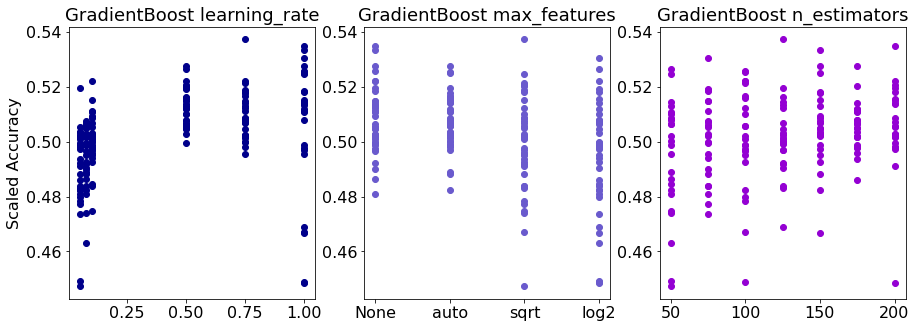

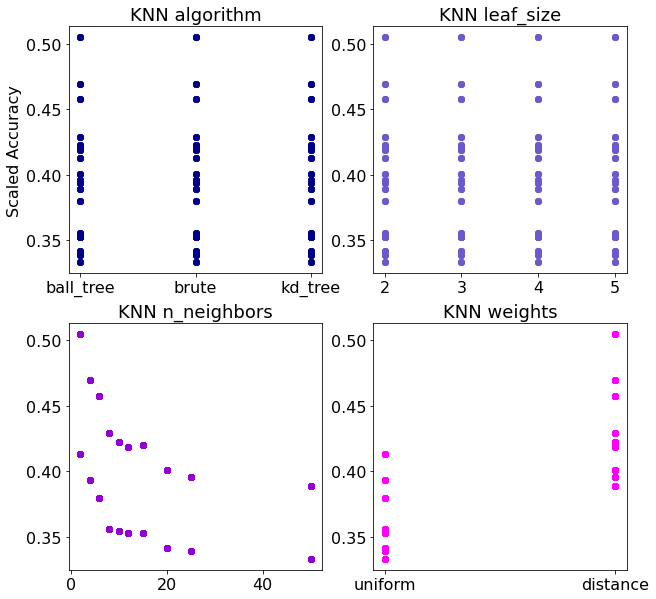

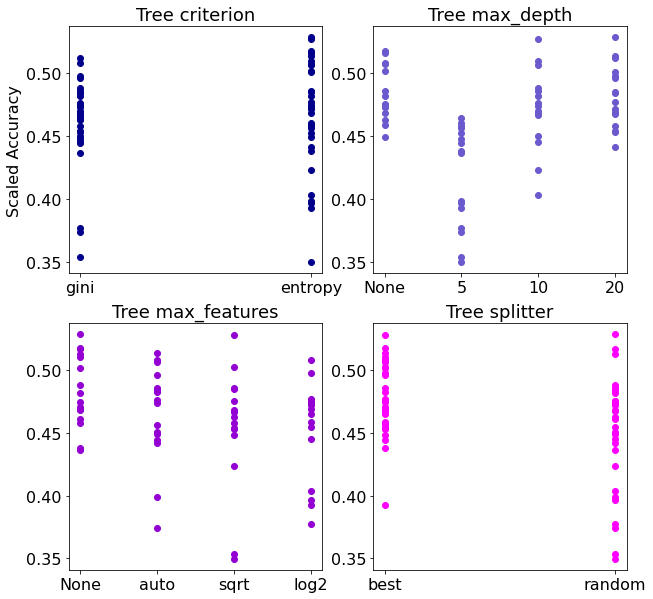

In [46]:
# SKLEARN MODEL PARAMETER STUDY
if modelParamStudy:
    
    # For this, use only three classifications
    if dataSet == 'Wine':
       y_new = comboTargets(y_train,cDesc="BAG2")
    elif dataSet == 'Student':
       y_new = y_train
    
    if modelParamCalc:
       print()
       pResults={}
       pBest={}
       colname=('Classifier','Param','P Val', 'Default','Best')
       for nm, clf, pg, pr in zip(skNames, skClassifiers, skGrid, skRandom):
           if (nm != 'All'):
              dCV = StratifiedKFold(n_splits=nCVSplits,shuffle=True)
              dscore = cross_val_score(clf, X=X_train, y=y_new, cv=dCV,
                                       scoring=scoreMethod)
              print(nm)
              print("   Default: {:.3f}".format(dscore.mean()))

              start_time = time.time()
              rclf = RandomizedSearchCV(estimator=clf, 
                                        param_distributions=pr,
                                        cv=dCV, scoring=scoreMethod,
                                        n_iter=nRSearch)
              rclf.fit(X_train,y_new)
              rTime = time.time() - start_time
              
              start_time = time.time()
              gclf = GridSearchCV(estimator=clf, param_grid=pg, 
                                  cv=dCV, scoring=scoreMethod)
              gclf.fit(X_train,y_new)
              gTime = time.time() - start_time
              
              pResults[nm] = gclf.cv_results_
              pBest[nm] = {'Default':dscore.mean(),
                           'GParams':gclf.best_params_,
                           'GScore':gclf.best_score_,
                           'GTime':gTime,
                           'RParams':rclf.best_params_,
                           'RScore':rclf.best_score_,
                           'RTime':rTime}
              
              pHere = gclf.best_params_
              tAcc = testCLF(nm, pHere)
              print("   Best Grid Train Acc: {:.3f} Test Acc: {:.3f} in {:.3f}s".
                    format(gclf.best_score_, tAcc, gTime))
              print("   Best Grid Params: {}".format(pHere))
              
              pHere = rclf.best_params_
              tAcc = testCLF(nm, pHere)
              print("   Best Random Acc: {:.3f} Test Acc: {:.3f} in {:.3f}s".
                    format(rclf.best_score_, tAcc, rTime))
              print("   Best Random Params: {}".format(rclf.best_params_))

       # Save results to pickle file
       if modelParamSave:
           with open(modelParamFile, 'wb') as handle:
                pickle.dump([pResults,pBest], handle, 
                        protocol=pickle.HIGHEST_PROTOCOL)

    else:
       # Open results from pickle file
       with open(mParamFile, 'rb') as handle:
           allTemp = pickle.load(handle)
           pResults = allTemp[0]
           pBest = allTemp[1]
    
    # Plot parameter results
    if makeModelParamPlots:
       for name, clf, params in zip(skNames, skClassifiers, skGrid):
           if (name != 'All'):
              cResults = pResults[name]
              nParams = len(list(params.keys()))
              if nParams == 1:
                  nrows=1
                  ncols=1
                  figsize=(6,6)
              elif nParams == 2:
                  nrows=1
                  ncols=2
                  figsize=(15,8)
              elif nParams == 3:
                  nrows=1
                  ncols=3
                  figsize=(15,5)
              elif nParams == 4:
                  nrows=2
                  ncols=2
                  figsize=(10,10)
              elif nParams == 5:
                  nrows=2
                  ncols=3
                  figsize=(15,15)
              elif nParams == 6:
                  nrows=2
                  ncols=3
                  figsize=(15,15)
               
              f, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                                     figsize=figsize)
              count = 0
              for p in params:
                  pname = 'param_' + p
                  xs = cResults[pname]
                  fxs = type(xs[0])
                  fbool = all(isinstance(x,fxs) for x in xs)
                  if not fbool:
                      xs = [f'{e}' for e in xs]
                  xs = ['None' if v is None else v for v in xs]
                  ys = cResults['mean_test_score']
                  if nParams == 1:
                      axes.scatter(xs, ys, color=modelColors[count])
                      myTitle = name + ' ' + p
                      axes.set_title(myTitle)
                      axes.set_ylabel('Scaled Acuracy')
                  elif nParams < 4:
                     axes[count].scatter(xs, ys, color=modelColors[count])
                     myTitle = name + ' '+ p
                     axes[count].set_title(myTitle)
                     if (count % 3) == 0:
                        axes[count].set_ylabel('Scaled Accuracy')
                  elif nParams == 4:
                      if count==0:
                          axes[0][0].scatter(xs, ys, color=modelColors[count])
                          axes[0][0].set_ylabel('Scaled Accuracy')
                          myTitle = name + ' ' + p
                          axes[0][0].set_title(myTitle)
                      elif count==1:
                          axes[0][1].scatter(xs, ys, color=modelColors[count])
                          myTitle = name + ' '+ p
                          axes[0][1].set_title(myTitle)
                      elif count==2:
                          axes[1][0].scatter(xs, ys, color=modelColors[count])
                          myTitle = name + ' '+ p
                          axes[1][0].set_title(myTitle)
                      elif count==3:
                          axes[1][1].scatter(xs, ys, color=modelColors[count])
                          myTitle = name + ' '+ p
                          axes[1][1].set_title(myTitle)
                  count += 1
                      
              if saveModelParamPlots:
                  myFilename = dataSet + '_' + name + '_params.png'
                  plt.savefig(myFilename,bbox_inches='tight')
            
    # Plot performance results:
    if makeModelPerfPlots:
       
        nMethods = len(list(pBest.keys()))
        xs = []
        ysD = []
        ysG = []
        ysR = []
        ytG = []
        ytR = []
        for key, val in pBest.items():
             xs.append(key)
             ysD.append(pBest[key]['Default'])
             ysG.append(pBest[key]['GScore'])
             ysR.append(pBest[key]['RScore'])
             ytG.append(pBest[key]['GTime'])
             ytR.append(pBest[key]['RTime'])
        
        xs = ['None']
        xs.extend(classifierList)
        width = 0.3
        ind = np.arange(nMethods)-width/6.
        
        fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(9,9))
        axes[0].bar(ind-width, ysD, width, label='Default', color='b')
        axes[0].bar(ind, ysG, width, label='Grid', color='g')
        axes[0].bar(ind+width, ysR, width, label='Random', color='r')
        axes[0].set_xticklabels(xs)
        axes[0].set_title('Best Model Results')
        axes[0].set_ylabel('Accuracy')
        #plt.legend(loc='center right', bbox_to_anchor=(1.1,0.55), ncol=1,
        #           frameon=False, borderpad=2)
        axes[0].legend(loc='lower left')
        
        width2 = 0.4
        ind2 = np.arange(nMethods)-width/2.
        axes[1].bar(ind2, ytG, width2, color='g' )
        axes[1].bar(ind2+width2, ytR, width2, color='r')
        axes[1].set_title('Time')
        axes[1].set_xticklabels(xs)
        axes[1].set_ylabel('s')
        fig.tight_layout()
        
        if saveModelPerfPlots:
            myFilename = dataSet + '_pBestResults.png'
            plt.savefig(myFilename, bbox_inches='tight')
           